# Hudson Valley Gentrification and Changes in Farming

## Notebook 2: ACS Data

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shapely
import numpy as np
from censusdis import data as ced
#from censusdis.datasets import ACS5
from census import Census
import math
import requests

In [2]:
api_key_stadia = os.getenv("STADIA_API_KEY")
api_key_census = os.getenv("CENSUS_API_KEY")
api_key_nass = os.getenv("QUICK_STATS_API_KEY")

In [3]:
proj_nys_east = 26918
proj_hudson_ft = 32118
proj_nyc_ft = 2263
proj_ea = 6933
proj_latlon = 4326

In [4]:
def meters_to_miles(meters):
    return meters/1609
def miles_to_meters(miles):
    return miles*1609
def sqmeters_to_sqmiles(meters):
    return meters/2.59e+6
def sqmiles_to_sqmeters(miles):
    return miles*2.59e+6

## Import farms and tracts

In [5]:
gdf_farms_all = gpd.read_file("data/farms_core.geojson")

In [6]:
gdf_nys_tracts_2022 = gpd.read_file("data/tl_2022_36_tract.zip") # https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_36_tract.zip
gdf_nys_tracts_2017 = gpd.read_file("data/tl_2017_36_tract.zip") # https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_36_tract.zip

In [7]:
gdf_nys_counties = gpd.read_file("data/NYS_Civil_Boundaries_2455759864913236436.geojson")

In [8]:
gdf_farms = gdf_farms_all.query("moran == True").copy()

## Select tracts of interest

Identify tracts that fall partially or entirely within ten miles of any farm in the "core" cluster of market farms.

In [9]:
gdf_farms = gdf_farms.to_crs(proj_nys_east)

In [10]:
gdf_nys_tracts_2022 = gdf_nys_tracts_2022.to_crs(proj_nys_east)
gdf_nys_tracts_2017 = gdf_nys_tracts_2017.to_crs(proj_nys_east)

In [11]:
gdf_nys_counties = gdf_nys_counties.to_crs(proj_nys_east)

In [12]:
gdf_farms["buffer_10mi"] = gdf_farms.buffer(miles_to_meters(10)).geometry

<Axes: >

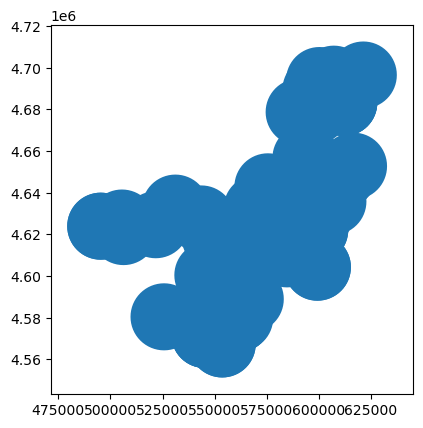

In [13]:
gdf_farms["buffer_10mi"].plot()

<Axes: >

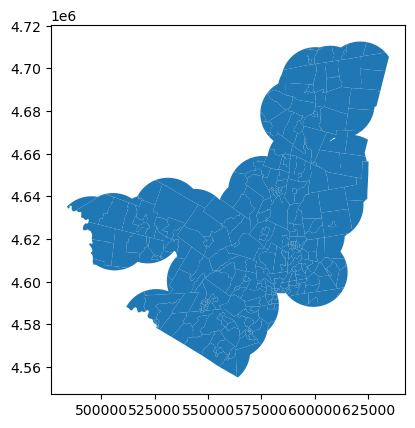

In [14]:
gdf_nys_tracts_2022.clip(gdf_farms["buffer_10mi"]).plot()

<Axes: >

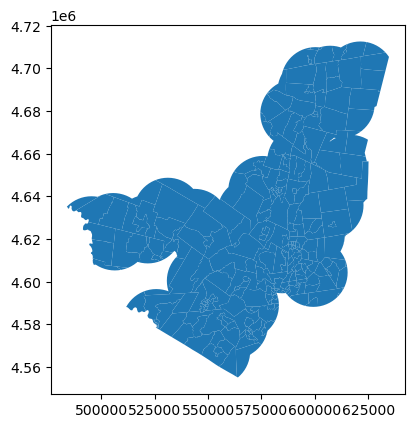

In [15]:
gdf_nys_tracts_2017.clip(gdf_farms["buffer_10mi"]).plot()

In [16]:
gdf_tracts_core_2022 = gdf_nys_tracts_2022[gdf_nys_tracts_2022.index.isin(gdf_nys_tracts_2022.sjoin(gdf_nys_tracts_2022.clip(gdf_farms["buffer_10mi"]), how="inner", predicate="intersects").index)].copy()

In [17]:
gdf_tracts_core_2017 = gdf_nys_tracts_2017[gdf_nys_tracts_2017.index.isin(gdf_nys_tracts_2017.sjoin(gdf_nys_tracts_2017.clip(gdf_farms["buffer_10mi"]), how="inner", predicate="intersects").index)].copy()

<Axes: >

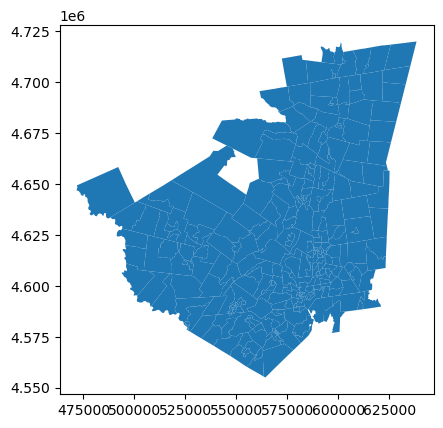

In [18]:
gdf_tracts_core_2022.plot()

<Axes: >

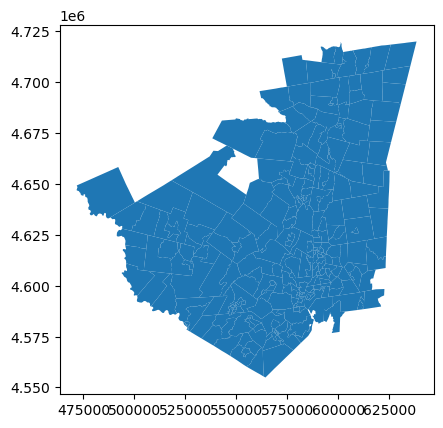

In [19]:
gdf_tracts_core_2017.plot()

In [20]:
gdf_tracts_core_2022.head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
104      36      105  951701  36105951701  9517.01  Census Tract 9517.01   
105      36      105  951801  36105951801  9518.01  Census Tract 9518.01   
106      36      105  951302  36105951302  9513.02  Census Tract 9513.02   
107      36      105  951802  36105951802  9518.02  Census Tract 9518.02   
108      36      105  950801  36105950801  9508.01  Census Tract 9508.01   

     MTFCC FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
104  G5020        S  80751463  4230629  +41.6252683  -074.6109770   
105  G5020        S   9416768   161484  +41.6353707  -074.6665861   
106  G5020        S  79633377   998387  +41.6346723  -074.4914470   
107  G5020        S   3677536    74552  +41.6500499  -074.7108274   
108  G5020        S  35408221  1338257  +41.7864811  -074.6607209   

                                              geometry  
104  POLYGON ((527485.433 4611964.593, 527486.865 4...  
105  POLYGON ((524469.064 4612440.958, 524508.046 4...  
106  POLYGON ((536422.502 4606104.963, 536528.422 4...  
107  POLYGON ((523228.27 4610556.874, 523249.305 46...  
108  POLYGON ((524576.278 4626499.536, 524679.494 4...

In [21]:
gdf_tracts_core_2017 = gdf_tracts_core_2017.assign(COUNTYFIPS = lambda df: df.STATEFP + df.COUNTYFP)

In [22]:
gdf_tracts_core_2022 = gdf_tracts_core_2022.assign(COUNTYFIPS = lambda df: df.STATEFP + df.COUNTYFP)
gdf_tracts_core_2022.head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
104      36      105  951701  36105951701  9517.01  Census Tract 9517.01   
105      36      105  951801  36105951801  9518.01  Census Tract 9518.01   
106      36      105  951302  36105951302  9513.02  Census Tract 9513.02   
107      36      105  951802  36105951802  9518.02  Census Tract 9518.02   
108      36      105  950801  36105950801  9508.01  Census Tract 9508.01   

     MTFCC FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
104  G5020        S  80751463  4230629  +41.6252683  -074.6109770   
105  G5020        S   9416768   161484  +41.6353707  -074.6665861   
106  G5020        S  79633377   998387  +41.6346723  -074.4914470   
107  G5020        S   3677536    74552  +41.6500499  -074.7108274   
108  G5020        S  35408221  1338257  +41.7864811  -074.6607209   

                                              geometry COUNTYFIPS  
104  POLYGON ((527485.433 4611964.593, 527486.865 4...      36105  
105  POLYGON ((524469.064 4612440.958, 524508.046 4...      36105  
106  POLYGON ((536422.502 4606104.963, 536528.422 4...      36105  
107  POLYGON ((523228.27 4610556.874, 523249.305 46...      36105  
108  POLYGON ((524576.278 4626499.536, 524679.494 4...      36105

In [23]:
gdf_counties_core = gdf_nys_counties.query("FIPS_CODE in @gdf_tracts_core_2022.COUNTYFIPS").copy()
gdf_counties_core

OBJECTID        NAME ABBREV GNIS_ID FIPS_CODE    SWIS NYSP_ZONE  POP1990  \
0          1      Albany   ALBA  974099     36001  010000      East   292594   
10        11    Columbia   COLU  974109     36021  100000      East    62982   
12        13    Delaware   DELA  974111     36025  120000      East    47225   
13        14    Dutchess   DUTC  974112     36027  130000      East   259462   
19        20      Greene   GREE  974118     36039  190000      East    44739   
35        36      Orange   ORAN  974134     36071  330000      East   307647   
39        40      Putnam   PUTN  974138     36079  370000      East    83941   
41        42  Rensselaer   RENS  974140     36083  380000      East   154429   
52        53    Sullivan   SULL  974150     36105  480000      East    69277   
55        56      Ulster   ULST  974153     36111  510000      East   165304   

    POP2000  POP2010  POP2020 DOS_LL DOSLL_DATE NYC   CALC_SQ_MI  \
0    294565   304204   314848   None       None   N   532.791779   
10    63094    63096    61570   None       None   N   647.905835   
12    48055    47980    44308   None       None   N  1466.338072   
13   280150   297488   295911   None       None   N   824.438109   
19    48195    49221    47931   None       None   N   657.720079   
35   341367   372813   401310   None       None   N   837.148961   
39    95745    99710    97668   None       None   N   245.989024   
41   152538   159429   161130   None       None   N   665.084035   
52    73966    77547    78624   None       None   N   995.439165   
55   177749   182493   181851   None       None   N  1161.254720   

                          DATEMOD  \
0   Fri, 10 Nov 2017 00:00:00 GMT   
10  Mon, 22 Jan 2018 00:00:00 GMT   
12  Tue, 19 May 2020 00:00:00 GMT   
13  Thu, 08 Nov 2018 00:00:00 GMT   
19  Tue, 19 May 2020 00:00:00 GMT   
35  Fri, 15 May 2020 00:00:00 GMT   
39  Thu, 08 Nov 2018 00:00:00 GMT   
41  Fri, 10 Nov 2017 00:00:00 GMT   
52  Fri, 15 May 2020 00:00:00 GMT   
55  Wed, 25 Oct 2017 00:00:00 GMT   

                                             geometry  
0   POLYGON ((608218.927 4737613.315, 608193.336 4...  
10  POLYGON ((624387.318 4656389.284, 624387.085 4...  
12  POLYGON ((523750.277 4707243.712, 523816.31 47...  
13  POLYGON ((624387.318 4656389.284, 624388.346 4...  
19  POLYGON ((590039.896 4664494.401, 589739.777 4...  
35  POLYGON ((587211.589 4604774.186, 587211.21 46...  
39  POLYGON ((622581.399 4598234.108, 622573.885 4...  
41  POLYGON ((640790.386 4756004.259, 640790.377 4...  
52  POLYGON ((552753.314 4604558.944, 552710.697 4...  
55  POLYGON ((590039.896 4664494.401, 589947.276 4...

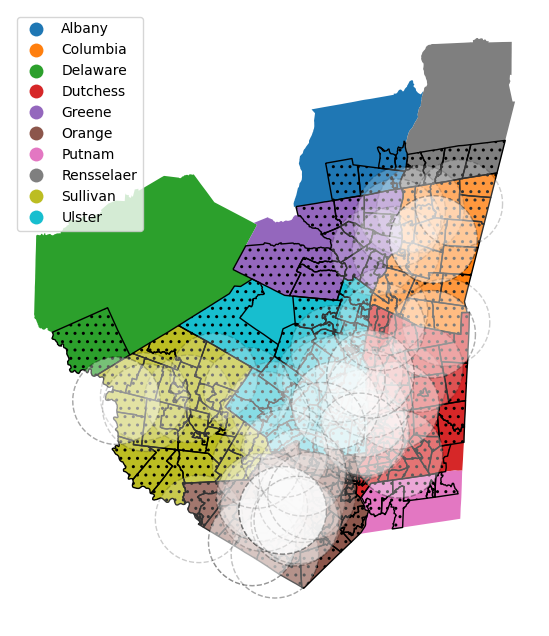

In [24]:
ax = gdf_counties_core.plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2022.plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
gdf_farms["buffer_10mi"].plot(ax=ax, facecolor="white", alpha=0.2, edgecolor="black", linestyle="--")
ax.axis("off");

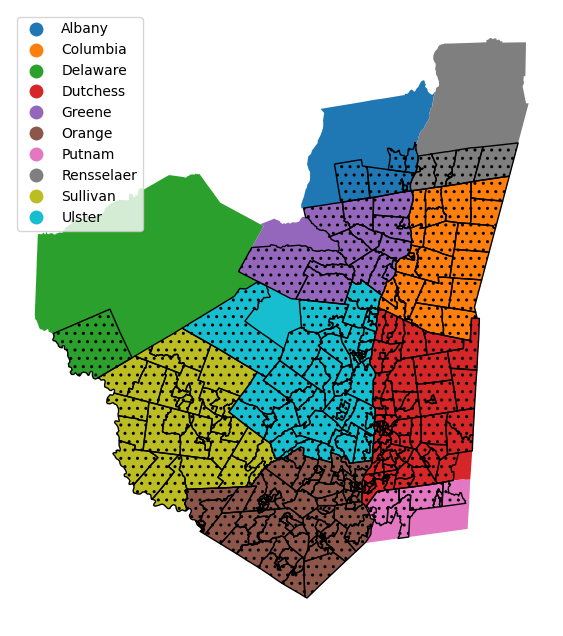

In [25]:
ax = gdf_counties_core.to_crs(proj_hudson_ft).plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2022.to_crs(proj_hudson_ft).plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
ax.axis("off");

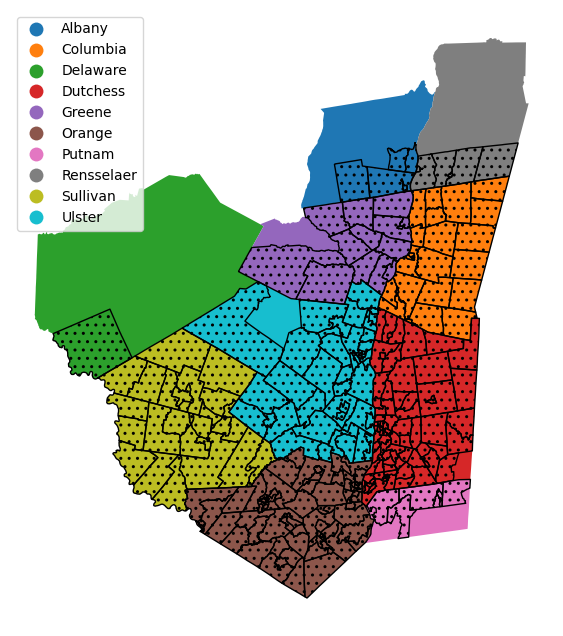

In [26]:
ax = gdf_counties_core.to_crs(proj_hudson_ft).plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2017.to_crs(proj_hudson_ft).plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
ax.axis("off");

In [27]:
gdf_tracts_core_2017.to_file("data/tracts_core_2017.geojson")
gdf_tracts_core_2022.to_file("data/tracts_core_2022.geojson")
gdf_counties_core.to_file("data/counties_core.geojson")

## Get ACS data

### Choose and refine variables

In [28]:
acs_years = ["2017", "2022"]

In [29]:
acs_var_grp_agg = ["B25039",'B25057','B25058','B25059','B25071','B19013']
acs_var_grp_raw = ['B01003',"B25003","B25038",'B25056','B25074','B25004','B19001']
acs_var_groups = acs_var_grp_agg + acs_var_grp_raw

In [30]:
c = Census(api_key_census)

In [31]:
acs5tables = pd.DataFrame.from_dict(c.acs5.tables())
acs5tables

name                                        description  \
0     B18104                 Sex by Age by Cognitive Difficulty   
1     B17015  Poverty Status in the Past 12 Months of Famili...   
2     B18105                Sex by Age by Ambulatory Difficulty   
3     B17016  Poverty Status in the Past 12 Months of Famili...   
4     B18106                 Sex by Age by Self-Care Difficulty   
...      ...                                                ...   
1188  B99131  Allocation of Marital Status for Females 15 to...   
1189  B09018  Relationship to Householder for Children Under...   
1190  B99132    Allocation of Fertility of Women 15 to 50 Years   
1191  B09019  Household Type (Including Living Alone) by Rel...   
1192  B09010  Receipt of Supplemental Security Income (SSI),...   

                                              variables  \
0     http://api.census.gov/data/2023/acs/acs5/group...   
1     http://api.census.gov/data/2023/acs/acs5/group...   
2     http://api.census.gov/data/2023/acs/acs5/group...   
3     http://api.census.gov/data/2023/acs/acs5/group...   
4     http://api.census.gov/data/2023/acs/acs5/group...   
...                                                 ...   
1188  http://api.census.gov/data/2023/acs/acs5/group...   
1189  http://api.census.gov/data/2023/acs/acs5/group...   
1190  http://api.census.gov/data/2023/acs/acs5/group...   
1191  http://api.census.gov/data/2023/acs/acs5/group...   
1192  http://api.census.gov/data/2023/acs/acs5/group...   

                                              universe   
0     Civilian noninstitutionalized population 5 yea...  
1                                              Families  
2     Civilian noninstitutionalized population 5 yea...  
3                                              Families  
4     Civilian noninstitutionalized population 5 yea...  
...                                                 ...  
1188                               Women 15 to 50 years  
1189  Population under 18 years in households (exclu...  
1190                               Women 15 to 50 years  
1191                                   Total population  
1192            Population under 18 years in households  

[1193 rows x 4 columns]

In [32]:
acs5tables = acs5tables.rename(columns={"universe ": "universe"})

In [33]:
acs5vars = acs5tables.query("name in @acs_var_groups")
acs5vars

name                                        description  \
231   B25039  Median Year Householder Moved Into Unit by Tenure   
232   B25038         Tenure by Year Householder Moved Into Unit   
318   B25004                                     Vacancy Status   
320   B25003                                             Tenure   
334   B25074  Household Income by Gross Rent as a Percentage...   
344   B25071  Median Gross Rent as a Percentage of Household...   
400   B25057             Lower Contract Rent Quartile (Dollars)   
401   B25056                                      Contract Rent   
402   B25059             Upper Contract Rent Quartile (Dollars)   
403   B25058                     Median Contract Rent (Dollars)   
503   B01003                                   Total Population   
1081  B19013  Median Household Income in the Past 12 Months ...   
1102  B19001  Household Income in the Past 12 Months (in 202...   

                                              variables  \
231   http://api.census.gov/data/2023/acs/acs5/group...   
232   http://api.census.gov/data/2023/acs/acs5/group...   
318   http://api.census.gov/data/2023/acs/acs5/group...   
320   http://api.census.gov/data/2023/acs/acs5/group...   
334   http://api.census.gov/data/2023/acs/acs5/group...   
344   http://api.census.gov/data/2023/acs/acs5/group...   
400   http://api.census.gov/data/2023/acs/acs5/group...   
401   http://api.census.gov/data/2023/acs/acs5/group...   
402   http://api.census.gov/data/2023/acs/acs5/group...   
403   http://api.census.gov/data/2023/acs/acs5/group...   
503   http://api.census.gov/data/2023/acs/acs5/group...   
1081  http://api.census.gov/data/2023/acs/acs5/group...   
1102  http://api.census.gov/data/2023/acs/acs5/group...   

                                            universe  
231                           Occupied housing units  
232                           Occupied housing units  
318                             Vacant housing units  
320                           Occupied housing units  
334                    Renter-occupied housing units  
344   Renter-occupied housing units paying cash rent  
400   Renter-occupied housing units paying cash rent  
401                    Renter-occupied housing units  
402   Renter-occupied housing units paying cash rent  
403   Renter-occupied housing units paying cash rent  
503                                 Total population  
1081                                      Households  
1102                                      Households

In [34]:
ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003")

{'NAME': {'label': 'Geographic Area Name',
  'concept': "Sex by Occupation for the Full-Time, Year-Round Civilian Employed Population 16 Years and Over;Sex by Industry for the Civilian Employed Population 16 Years and Over;Sex by Industry for the Full-Time, Year-Round Civilian Employed Population 16 Years and Over;Industry by Occupation for the Civilian Employed Population 16 Years and Over;Occupation by Class of Worker for the Civilian Employed Population 16 Years and Over;Industry by Class of Worker for the Civilian Employed Population 16 Years and Over;Health Insurance Coverage Status by Age (White Alone);Health Insurance Coverage Status by Age (Black or African American Alone);Health Insurance Coverage Status by Age (American Indian and Alaska Native Alone);Health Insurance Coverage Status by Age (Asian Alone);Health Insurance Coverage Status by Age (Native Hawaiian and Other Pacific Islander Alone);Health Insurance Coverage Status by Age (Some Other Race Alone);Health Insurance Co

In [35]:
ced.variables.get_group(dataset="acs/acs5", year=2017, name="B19001")

{'NAME': {'label': 'Geographic Area Name',
  'concept': "POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (AMERICAN INDIAN AND ALASKA NATIVE ALONE);POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (ASIAN ALONE);POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE);POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (SOME OTHER RACE ALONE);POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (TWO OR MORE RACES);POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (WHITE ALONE, NOT HISPANIC OR LATINO);POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (HISPANIC OR LATINO);POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EDUCATIONAL ATTAINMENT;POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY WORK EXPERIENCE;POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EMPLOYMENT STATUS;POVERTY STATUS IN THE PAST 12 MONTHS OF RELATED CHILDREN UNDER 18 YEARS BY FAMILY TYPE BY AGE OF RELATED CHILDREN UNDER 18 YEARS;POVE

In [36]:
acs5tables_2017 = ced.variables.all_groups('acs/acs5', 2017)
acs5tables_2017.head()

DATASET  YEAR    GROUP                                   DESCRIPTION
0  acs/acs5  2017   B00001     UNWEIGHTED SAMPLE COUNT OF THE POPULATION
1  acs/acs5  2017   B00002               UNWEIGHTED SAMPLE HOUSING UNITS
2  acs/acs5  2017   B01001                                    SEX BY AGE
3  acs/acs5  2017  B01001A                      SEX BY AGE (WHITE ALONE)
4  acs/acs5  2017  B01001B  SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)

In [37]:
acs5tables_2022 = ced.variables.all_groups('acs/acs5', 2022)
acs5tables_2022.head()

DATASET  YEAR    GROUP                                        DESCRIPTION
0  acs/acs5  2022   B01001                                         Sex by Age
1  acs/acs5  2022  B01001A                           Sex by Age (White Alone)
2  acs/acs5  2022  B01001B       Sex by Age (Black or African American Alone)
3  acs/acs5  2022  B01001C  Sex by Age (American Indian and Alaska Native ...
4  acs/acs5  2022  B01001D                           Sex by Age (Asian Alone)

In [38]:
acsvar_dict = {}
for year in acs_years:
    acsvar_dict[year] = {}
    for acsvar in acs_var_groups:
        universe = acs5tables.query("name == @acsvar")["universe"].values[0]
        yeartable = eval(f'acs5tables_{year}')
        description = yeartable.query("GROUP == @acsvar").DESCRIPTION.values[0]
        acsvar_dict[year][acsvar] = {"universe": universe,
                            "description": description,
                            "variables": []}
    #    print(acs5tables.query(f"name == @acsvar")["universe"].values[0], "-", acs5tables.query("name == @acsvar").description.values[0])
        varget = ced.variables.get_group(dataset="acs/acs5", year=int(year), name=acsvar)
        for var in varget:
            if var[-1] == 'E' and var != 'NAME':
    #            print(varget[var]['name'], varget[var]['label'], f"({varget[var]['predicateType']})")
                acsvar_dict[year][acsvar]['variables'].append({'variable': varget[var]['name'],
                                                        'label': varget[var]['label'],
                                                        'type': varget[var]['predicateType']})
acsvar_dict

{'2017': {'B25039': {'universe': 'Occupied housing units',
   'description': 'MEDIAN YEAR HOUSEHOLDER MOVED INTO UNIT BY TENURE',
   'variables': [{'variable': 'B25039_002E',
     'label': 'Estimate!!Median year householder moved into unit --!!Owner occupied',
     'type': 'int'},
    {'variable': 'B25039_001E',
     'label': 'Estimate!!Median year householder moved into unit --!!Total',
     'type': 'int'},
    {'variable': 'B25039_003E',
     'label': 'Estimate!!Median year householder moved into unit --!!Renter occupied',
     'type': 'int'}]},
  'B25057': {'universe': 'Renter-occupied housing units paying cash rent',
   'description': 'LOWER CONTRACT RENT QUARTILE (DOLLARS)',
   'variables': [{'variable': 'B25057_001E',
     'label': 'Estimate!!Lower contract rent quartile',
     'type': 'int'}]},
  'B25058': {'universe': 'Renter-occupied housing units paying cash rent',
   'description': 'MEDIAN CONTRACT RENT (DOLLARS)',
   'variables': [{'variable': 'B25058_001E',
     'label': '

In [39]:
acs5_fields = ['NAME']
for year in acs_years:
    for var in acsvar_dict[year]:
        for var2 in acsvar_dict[year][var]['variables']:
            if year == '2017':
                acs5_fields.append(var2['variable'])
            else:
                pass
acs5_fields

['NAME',
 'B25039_002E',
 'B25039_001E',
 'B25039_003E',
 'B25057_001E',
 'B25058_001E',
 'B25059_001E',
 'B25071_001E',
 'B19013_001E',
 'B01003_001E',
 'B25003_003E',
 'B25003_002E',
 'B25003_001E',
 'B25038_011E',
 'B25038_010E',
 'B25038_015E',
 'B25038_014E',
 'B25038_013E',
 'B25038_012E',
 'B25038_003E',
 'B25038_002E',
 'B25038_001E',
 'B25038_008E',
 'B25038_007E',
 'B25038_006E',
 'B25038_005E',
 'B25038_004E',
 'B25038_009E',
 'B25056_018E',
 'B25056_019E',
 'B25056_016E',
 'B25056_017E',
 'B25056_014E',
 'B25056_015E',
 'B25056_012E',
 'B25056_013E',
 'B25056_010E',
 'B25056_011E',
 'B25056_026E',
 'B25056_027E',
 'B25056_024E',
 'B25056_025E',
 'B25056_022E',
 'B25056_023E',
 'B25056_020E',
 'B25056_021E',
 'B25056_009E',
 'B25056_008E',
 'B25056_006E',
 'B25056_007E',
 'B25056_004E',
 'B25056_005E',
 'B25056_002E',
 'B25056_003E',
 'B25056_001E',
 'B25074_001E',
 'B25074_003E',
 'B25074_002E',
 'B25074_005E',
 'B25074_004E',
 'B25074_007E',
 'B25074_006E',
 'B25074_009E',

In [40]:
county_fips = list(gdf_tracts_core_2022.COUNTYFP.unique())

In [41]:
tract_fips_2017 = list(gdf_tracts_core_2017.TRACTCE)
tract_fips_2022 = list(gdf_tracts_core_2022.TRACTCE)

In [42]:
gdf_tracts_core_2017.head(1)

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
292      36      105  950800  36105950800  9508  Census Tract 9508  G5020   

    FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
292        S  83049493  1537088  +41.7707267  -074.6178671   

                                              geometry COUNTYFIPS  
292  POLYGON ((524576.278 4626499.536, 524679.494 4...      36105

### Get ACS data

In [43]:
acs_tracts_data = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year),
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        tract='*'
    )
    acs_tracts_data.append(data)

In [44]:
acs_tracts_data[0].head()

STATE COUNTY   TRACT                                        NAME  \
0    36    111  950600  Census Tract 9506, Ulster County, New York   
1    36    111  951100  Census Tract 9511, Ulster County, New York   
2    36    111  951800  Census Tract 9518, Ulster County, New York   
3    36    111  953000  Census Tract 9530, Ulster County, New York   
4    36    111  954900  Census Tract 9549, Ulster County, New York   

   B25039_002E  B25039_001E  B25039_003E  B25057_001E  B25058_001E  \
0       1996.0       1999.0       2012.0        823.0        942.0   
1       1998.0       2001.0       2012.0        906.0        985.0   
2       2000.0       2006.0       2010.0        480.0        683.0   
3       2002.0       2004.0       2011.0        667.0        735.0   
4       1993.0       1999.0          NaN        862.0       1044.0   

   B25059_001E  ...  B19001_005E  B19001_001E  B19001_014E  B19001_015E  \
0        994.0  ...           42         1379          102          127   
1       1112.0  ...           41         1122           80          169   
2        975.0  ...           55          721           60           30   
3        894.0  ...           60          743           98           54   
4       1207.0  ...           32          570           51           15   

   B19001_016E  B19001_017E  B19001_010E  B19001_011E  B19001_012E  \
0           97          247           37           80          161   
1           60          105           18           68           59   
2           64            5           11           39           44   
3           41           52           40           43           68   
4           43           11           10           62           74   

   B19001_013E  
0          138  
1          136  
2           53  
3           90  
4           97  

[5 rows x 147 columns]

In [45]:
acs_tracts_data[0].query('TRACT in @gdf_tracts_core_2017.TRACTCE').info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 0 to 414
Columns: 147 entries, STATE to B19001_013E
dtypes: float64(8), int64(135), object(4)
memory usage: 363.1+ KB


In [46]:
acs_tracts_data[1].query('TRACT in @gdf_tracts_core_2022.TRACTCE').info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 468
Columns: 147 entries, STATE to B19001_013E
dtypes: float64(5), int64(135), object(7)
memory usage: 396.6+ KB


In [47]:
for year in acs_years:
    for vargroup in acs_var_groups:
        num = acs_years.index(year)
        data_df = acs_tracts_data[num].query(f'TRACT in @gdf_tracts_core_{year}.TRACTCE')
        for var in acsvar_dict[year][vargroup]['variables']:
            columns = ['STATE','COUNTY','TRACT','NAME'] + [var['variable']]
            var['data'] = data_df[columns].copy()
acsvar_dict

{'2017': {'B25039': {'universe': 'Occupied housing units',
   'description': 'MEDIAN YEAR HOUSEHOLDER MOVED INTO UNIT BY TENURE',
   'variables': [{'variable': 'B25039_002E',
     'label': 'Estimate!!Median year householder moved into unit --!!Owner occupied',
     'type': 'int',
     'data':     STATE COUNTY   TRACT                                          NAME  \
     0      36    111  950600    Census Tract 9506, Ulster County, New York   
     1      36    111  951100    Census Tract 9511, Ulster County, New York   
     2      36    111  951800    Census Tract 9518, Ulster County, New York   
     3      36    111  953000    Census Tract 9530, Ulster County, New York   
     4      36    111  954900    Census Tract 9549, Ulster County, New York   
     ..    ...    ...     ...                                           ...   
     406    36    001  000700       Census Tract 7, Albany County, New York   
     409    36    001  012700     Census Tract 127, Albany County, New York   


In [48]:
acs5vars

name                                        description  \
231   B25039  Median Year Householder Moved Into Unit by Tenure   
232   B25038         Tenure by Year Householder Moved Into Unit   
318   B25004                                     Vacancy Status   
320   B25003                                             Tenure   
334   B25074  Household Income by Gross Rent as a Percentage...   
344   B25071  Median Gross Rent as a Percentage of Household...   
400   B25057             Lower Contract Rent Quartile (Dollars)   
401   B25056                                      Contract Rent   
402   B25059             Upper Contract Rent Quartile (Dollars)   
403   B25058                     Median Contract Rent (Dollars)   
503   B01003                                   Total Population   
1081  B19013  Median Household Income in the Past 12 Months ...   
1102  B19001  Household Income in the Past 12 Months (in 202...   

                                              variables  \
231   http://api.census.gov/data/2023/acs/acs5/group...   
232   http://api.census.gov/data/2023/acs/acs5/group...   
318   http://api.census.gov/data/2023/acs/acs5/group...   
320   http://api.census.gov/data/2023/acs/acs5/group...   
334   http://api.census.gov/data/2023/acs/acs5/group...   
344   http://api.census.gov/data/2023/acs/acs5/group...   
400   http://api.census.gov/data/2023/acs/acs5/group...   
401   http://api.census.gov/data/2023/acs/acs5/group...   
402   http://api.census.gov/data/2023/acs/acs5/group...   
403   http://api.census.gov/data/2023/acs/acs5/group...   
503   http://api.census.gov/data/2023/acs/acs5/group...   
1081  http://api.census.gov/data/2023/acs/acs5/group...   
1102  http://api.census.gov/data/2023/acs/acs5/group...   

                                            universe  
231                           Occupied housing units  
232                           Occupied housing units  
318                             Vacant housing units  
320                           Occupied housing units  
334                    Renter-occupied housing units  
344   Renter-occupied housing units paying cash rent  
400   Renter-occupied housing units paying cash rent  
401                    Renter-occupied housing units  
402   Renter-occupied housing units paying cash rent  
403   Renter-occupied housing units paying cash rent  
503                                 Total population  
1081                                      Households  
1102                                      Households

In [49]:
acsvar_dict['2017']['B01003']['variables'][0]['data']

STATE COUNTY   TRACT                                          NAME  \
0      36    111  950600    Census Tract 9506, Ulster County, New York   
1      36    111  951100    Census Tract 9511, Ulster County, New York   
2      36    111  951800    Census Tract 9518, Ulster County, New York   
3      36    111  953000    Census Tract 9530, Ulster County, New York   
4      36    111  954900    Census Tract 9549, Ulster County, New York   
..    ...    ...     ...                                           ...   
406    36    001  000700       Census Tract 7, Albany County, New York   
409    36    001  012700     Census Tract 127, Albany County, New York   
410    36    001  012900     Census Tract 129, Albany County, New York   
413    36    001  014302  Census Tract 143.02, Albany County, New York   
414    36    021  000100     Census Tract 1, Columbia County, New York   

     B01003_001E  
0           2643  
1           2361  
2           1680  
3           1907  
4           1368  
..           ...  
406         3711  
409         2550  
410         3439  
413         8458  
414         2367  

[314 rows x 5 columns]

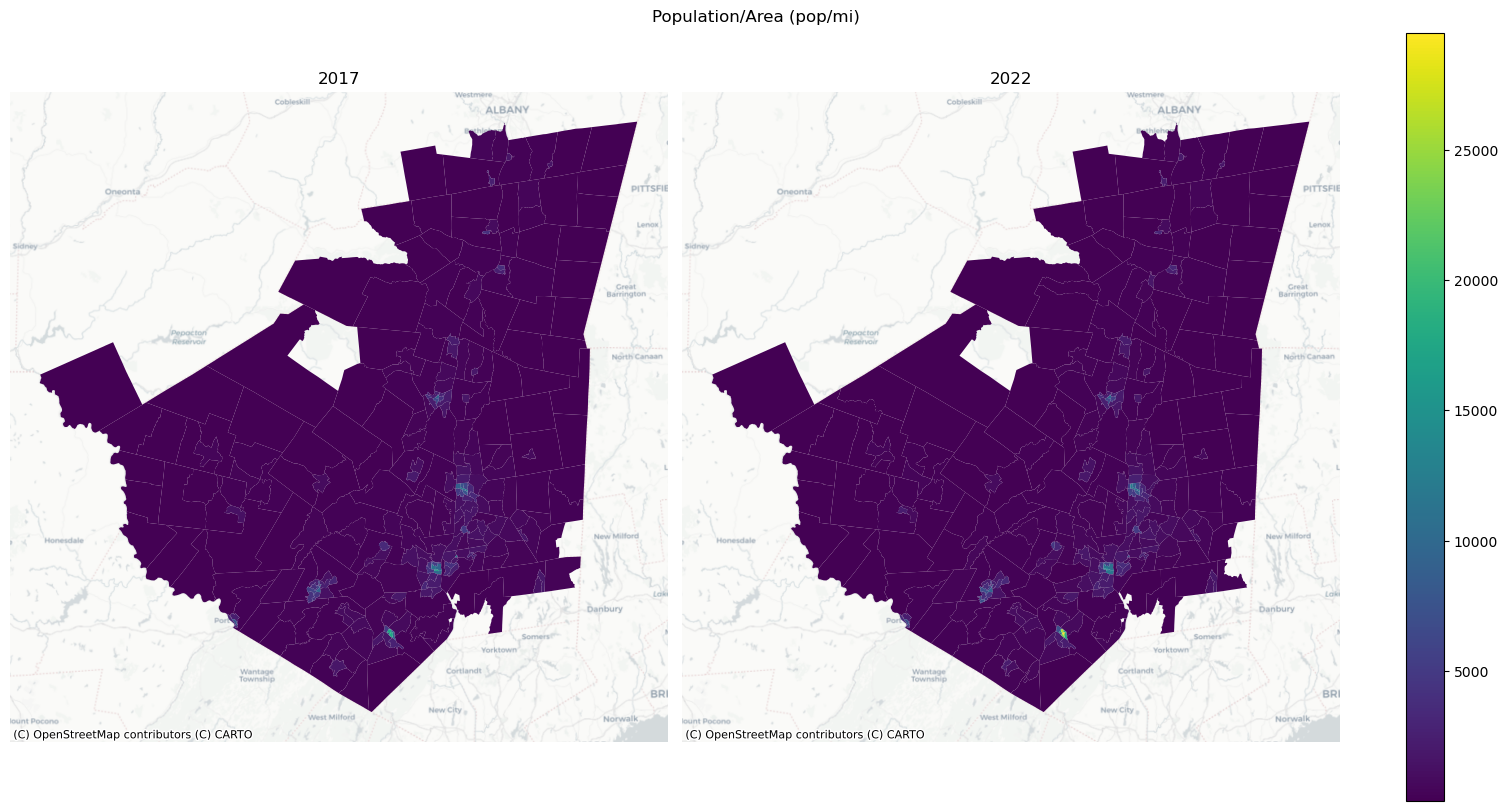

In [50]:
pop2017 = gdf_tracts_core_2017.merge(acsvar_dict['2017']['B01003']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT']).assign(pop_area = lambda df: df.B01003_001E/sqmeters_to_sqmiles(df.ALAND))
pop2022 = gdf_tracts_core_2022.merge(acsvar_dict['2022']['B01003']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT']).assign(pop_area = lambda df: df.B01003_001E/sqmeters_to_sqmiles(df.ALAND))
vmin = min([pop2017.pop_area.min(),pop2022.pop_area.min()])
vmax = max([pop2017.pop_area.max(),pop2022.pop_area.max()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(15,8))
pop2017.plot(column='pop_area', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()
pop2022.plot(column='pop_area', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=pop2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Population/Area (pop/mi)");

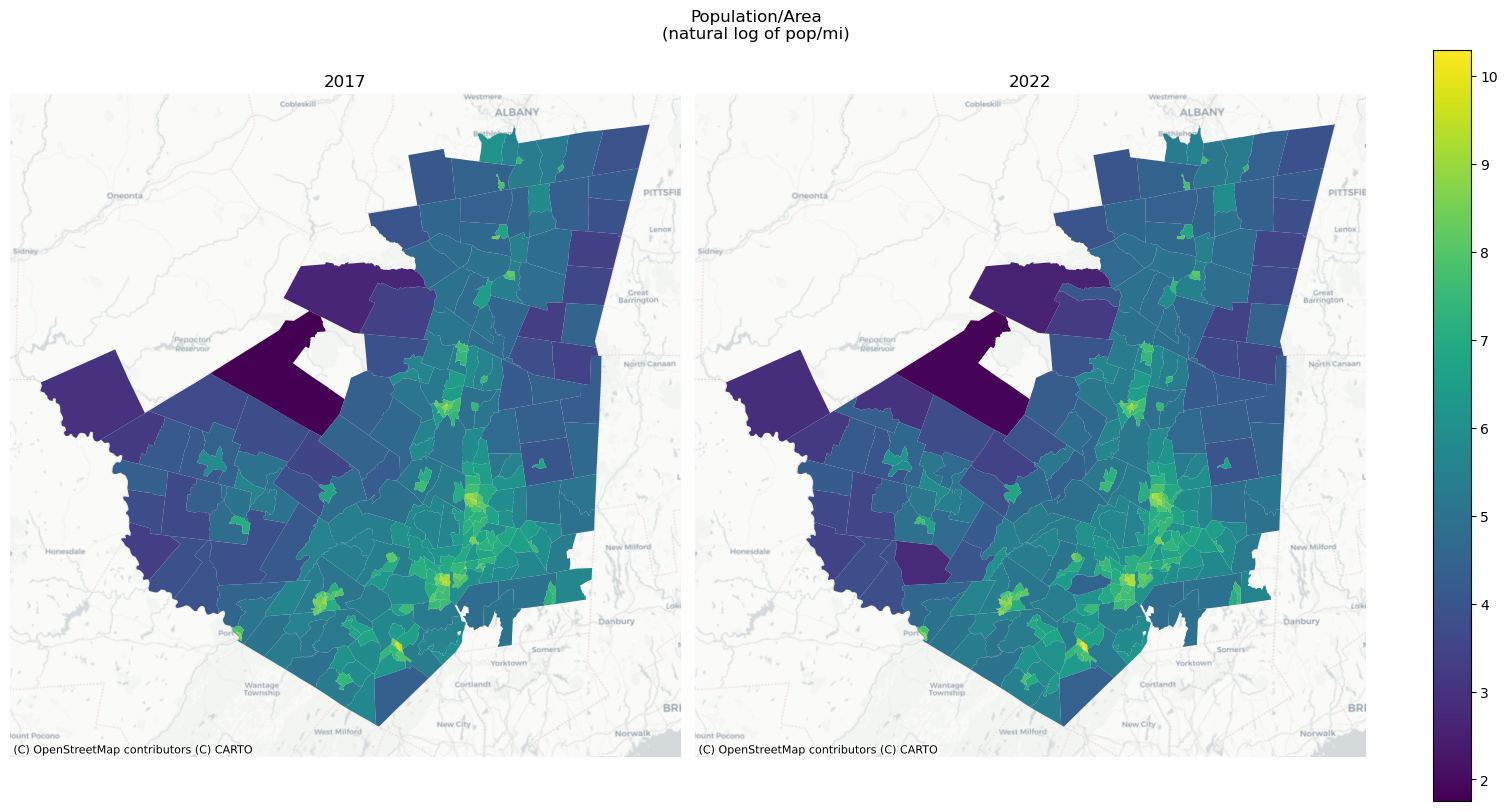

In [51]:
pop2017 = gdf_tracts_core_2017.merge(acsvar_dict['2017']['B01003']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT']).assign(pop_area = lambda df: df.B01003_001E/sqmeters_to_sqmiles(df.ALAND)).assign(pop_area = lambda df: df.pop_area.apply(math.log))
pop2022 = gdf_tracts_core_2022.merge(acsvar_dict['2022']['B01003']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT']).assign(pop_area = lambda df: df.B01003_001E/sqmeters_to_sqmiles(df.ALAND)).assign(pop_area = lambda df: df.pop_area.apply(math.log))
vmin = min([pop2017.pop_area.min(),pop2022.pop_area.min()])
vmax = max([pop2017.pop_area.max(),pop2022.pop_area.max()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(15,8))
pop2017.plot(column='pop_area', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()
pop2022.plot(column='pop_area', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=pop2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Population/Area\n(natural log of pop/mi)");

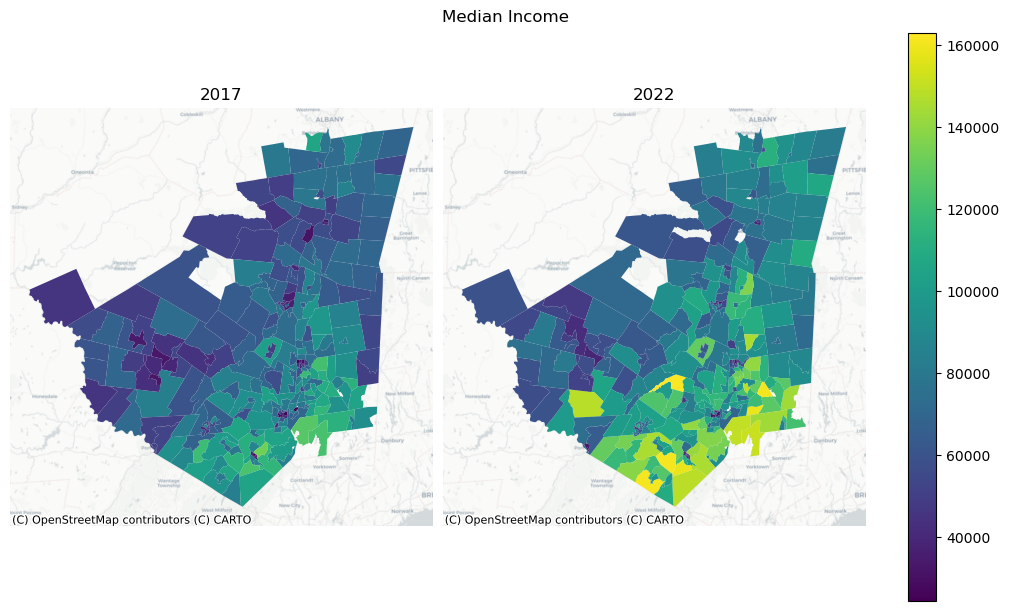

In [52]:
income2017 = gdf_tracts_core_2017.merge(acsvar_dict['2017']['B19013']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT'])
income2022 = gdf_tracts_core_2022.merge(acsvar_dict['2022']['B19013']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT'])
vmin = min([income2017.B19013_001E.min(),income2022.B19013_001E.min()])
vmax = max([income2017.B19013_001E.max(),income2022.B19013_001E.max()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,6))
income2017.plot(column='B19013_001E', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()
income2022.plot(column='B19013_001E', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=income2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Median Income");

### Interpolate null values

Wherever possible, replace null values with the following year's value; if that's also null, try the preceding year's value.

In [53]:
print(acs_tracts_data[0].isna().sum().sum())
print(acs_tracts_data[1].isna().sum().sum())

78
109


In [54]:
acs_tracts_data_nextyear = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year)+1,
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        tract='*'
    )
    acs_tracts_data_nextyear.append(data)

In [55]:
print(acs_tracts_data_nextyear[0].isna().sum().sum())
print(acs_tracts_data_nextyear[1].isna().sum().sum())

74
107


In [56]:
acs_tracts_data_prevyear = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year)-1,
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        tract='*'
    )
    acs_tracts_data_prevyear.append(data)

In [57]:
print(acs_tracts_data_prevyear[0].isna().sum().sum())
print(acs_tracts_data_prevyear[1].isna().sum().sum())

83
110


In [58]:
for i, df in enumerate(acs_tracts_data):
    for idx, row in df.iterrows():
        county = row['COUNTY']
        tract = row['TRACT']
        for col in row.index:
            dp = row[col]
            try:
                if type(dp) == float and np.isnan(dp):
                    nextyear_idx = acs_tracts_data_nextyear[i].index[(acs_tracts_data_nextyear[i]['COUNTY'] == county) & (acs_tracts_data_nextyear[i]['TRACT'] == tract)][0]
                    new_dp = acs_tracts_data_nextyear[i].loc[nextyear_idx, col]
                    df.loc[idx, col] = new_dp
                    if np.isnan(new_dp):
                        prevyear_idx = acs_tracts_data_prevyear[i].index[(acs_tracts_data_prevyear[i]['COUNTY'] == county) & (acs_tracts_data_prevyear[i]['TRACT'] == tract)][0]
                        new_dp = acs_tracts_data_prevyear[i].loc[prevyear_idx, col]
                        df.loc[idx, col] = new_dp
            except:
                pass

In [59]:
print(acs_tracts_data[0].isna().sum().sum())
print(acs_tracts_data[1].isna().sum().sum())

44
38


### Combine ACS5 data with tract data

In [60]:
gdf_tracts_core_2017.head(1)

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
292      36      105  950800  36105950800  9508  Census Tract 9508  G5020   

    FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
292        S  83049493  1537088  +41.7707267  -074.6178671   

                                              geometry COUNTYFIPS  
292  POLYGON ((524576.278 4626499.536, 524679.494 4...      36105

In [61]:
gdf_tracts_core_acsvars = []
for i, year in enumerate(acs_years):
    df = eval(f"gdf_tracts_core_{year}").copy()
    df = df.merge(acs_tracts_data[i], how="left", left_on=['STATEFP', 'COUNTYFP', 'TRACTCE'], right_on=['STATE','COUNTY','TRACT'])
    df.drop(['STATE','COUNTY','TRACT'], axis=1, inplace=True)
    gdf_tracts_core_acsvars.append(df.copy())

gdf_tracts_core_acsvars[0].head(1)

STATEFP COUNTYFP TRACTCE        GEOID NAME_x           NAMELSAD  MTFCC  \
0      36      105  950800  36105950800   9508  Census Tract 9508  G5020   

  FUNCSTAT     ALAND   AWATER  ... B19001_005E B19001_001E B19001_014E  \
0        S  83049493  1537088  ...          38        1549         131   

  B19001_015E B19001_016E  B19001_017E  B19001_010E  B19001_011E  B19001_012E  \
0          41          56           47           92          117          140   

   B19001_013E  
0          146  

[1 rows x 158 columns]

In [62]:
gdf_tracts_core_acsvars[0].isna().sum().sum()

np.int64(27)

In [63]:
gdf_tracts_core_acsvars[1].isna().sum().sum()

np.int64(30)

In [64]:
gdf_tracts_core_acsvars[0].tail()

STATEFP COUNTYFP TRACTCE        GEOID   NAME_x              NAMELSAD  \
273      36      027  060302  36027060302   603.02   Census Tract 603.02   
274      36      027  060400  36027060400      604      Census Tract 604   
275      36      027  640002  36027640002  6400.02  Census Tract 6400.02   
276      36      027  130004  36027130004  1300.04  Census Tract 1300.04   
277      36      027  050104  36027050104   501.04   Census Tract 501.04   

     MTFCC FUNCSTAT     ALAND  AWATER  ... B19001_005E B19001_001E  \
273  G5020        S  15728818  317610  ...          38        1092   
274  G5020        S   2119351   11273  ...          35        1011   
275  G5020        S   2304852   13876  ...           9          58   
276  G5020        S  24394742  363638  ...          24         610   
277  G5020        S  25376694  233911  ...          36        2202   

    B19001_014E B19001_015E B19001_016E  B19001_017E  B19001_010E  \
273         175          54         185          144           32   
274         119          85          83           20           17   
275           0           0           0            0            0   
276          69          67          83           67           20   
277         262         166         316          523           54   

     B19001_011E  B19001_012E  B19001_013E  
273           70          129           57  
274           93           72          141  
275            0            0            0  
276           30           58          101  
277          212          238          206  

[5 rows x 158 columns]

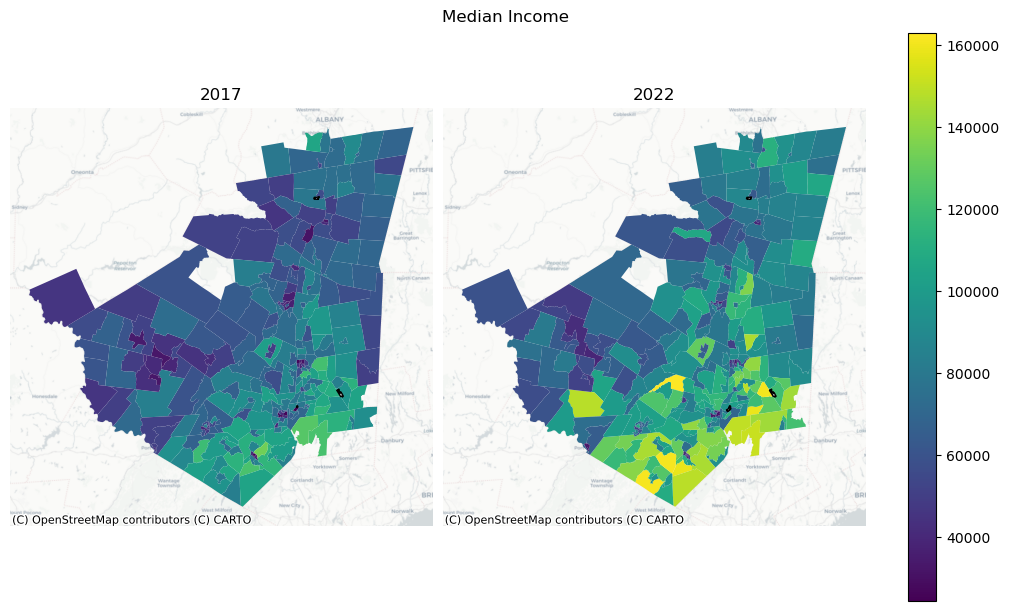

In [65]:
vmin = min([gdf_tracts_core_acsvars[0]['B19013_001E'].min(),gdf_tracts_core_acsvars[1]['B19013_001E'].min()])
vmax = max([gdf_tracts_core_acsvars[0]['B19013_001E'].max(),gdf_tracts_core_acsvars[1]['B19013_001E'].max()])
missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "////",
        "label": "Missing values",
    }

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,6))
gdf_tracts_core_acsvars[0].plot(column='B19013_001E', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis', missing_kwds=missing_kwds).set_axis_off()
gdf_tracts_core_acsvars[1].plot(column='B19013_001E', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis', missing_kwds=missing_kwds).set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=income2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Median Income");

In [66]:
gdf_tracts_core_acsvars[0].to_csv("data/core_tracts_acs5_2017_interp.csv", index=False, encoding='utf-8')
gdf_tracts_core_acsvars[1].to_csv("data/core_tracts_acs5_2022_interp.csv", index=False, encoding='utf-8')

In [67]:
## REPLACE DATA DICTIONARY DF COLUMNS WITH INTERPOLATED COLUMNS
for i, year in enumerate(acs_years):
    for vargroup in acsvar_dict[year]:
        for var in acsvar_dict[year][vargroup]['variables']:
            df = var['data']
            varname = var['data'].iloc[:,-1].name
            
            df[varname] = gdf_tracts_core_acsvars[i][varname]

In [68]:
acsvar_dict_nodf = acsvar_dict

In [69]:
for year in acsvar_dict_nodf.keys():
    for vargroup in acsvar_dict_nodf[year]:
        for var in acsvar_dict_nodf[year][vargroup]['variables']:
            del var['data']
acsvar_dict_nodf

{'2017': {'B25039': {'universe': 'Occupied housing units',
   'description': 'MEDIAN YEAR HOUSEHOLDER MOVED INTO UNIT BY TENURE',
   'variables': [{'variable': 'B25039_002E',
     'label': 'Estimate!!Median year householder moved into unit --!!Owner occupied',
     'type': 'int'},
    {'variable': 'B25039_001E',
     'label': 'Estimate!!Median year householder moved into unit --!!Total',
     'type': 'int'},
    {'variable': 'B25039_003E',
     'label': 'Estimate!!Median year householder moved into unit --!!Renter occupied',
     'type': 'int'}]},
  'B25057': {'universe': 'Renter-occupied housing units paying cash rent',
   'description': 'LOWER CONTRACT RENT QUARTILE (DOLLARS)',
   'variables': [{'variable': 'B25057_001E',
     'label': 'Estimate!!Lower contract rent quartile',
     'type': 'int'}]},
  'B25058': {'universe': 'Renter-occupied housing units paying cash rent',
   'description': 'MEDIAN CONTRACT RENT (DOLLARS)',
   'variables': [{'variable': 'B25058_001E',
     'label': '

In [70]:
import json

with open("data/acs_vars.json", "w") as acsvarfile:
    json.dump(acsvar_dict_nodf, acsvarfile)

## Crosswalk census block groups

### Get and interpolate block group data for 2017 and 2022

In [71]:
acs_bg_data = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year),
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
#        tract=eval(f'tract_fips_{year}'),
        block_group='*'
    )
    acs_bg_data.append(data)

In [72]:
acs_bg_data[0].head(1)

STATE COUNTY   TRACT BLOCK_GROUP  \
0    36    071  000501           1   

                                                NAME  B25039_002E  \
0  Block Group 1, Census Tract 5.01, Orange Count...       2002.0   

   B25039_001E  B25039_003E  B25057_001E  B25058_001E  ...  B19001_005E  \
0       2011.0       2012.0        661.0        909.0  ...           17   

   B19001_001E  B19001_014E  B19001_015E  B19001_016E  B19001_017E  \
0          524            0           17           21           24   

   B19001_010E  B19001_011E  B19001_012E  B19001_013E  
0           50           77           22           12  

[1 rows x 148 columns]

In [73]:
acs_bg_data[0].isna().sum().sum()

np.int64(1708)

In [74]:
acs_bg_data[1].isna().sum().sum()

np.int64(1951)

In [75]:
acs_bg_data_nextyear = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year)+1,
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        block_group='*'
    )
    acs_bg_data_nextyear.append(data)

In [76]:
acs_bg_data_prevyear = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year)-1,
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        block_group='*'
    )
    acs_bg_data_prevyear.append(data)

In [77]:
acs_bg_data_nextyear[0].head(1)

STATE COUNTY   TRACT BLOCK_GROUP  \
0    36    071  011802           2   

                                                NAME  B25039_002E  \
0  Block Group 2, Census Tract 118.02, Orange Cou...       1999.0   

   B25039_001E  B25039_003E  B25057_001E  B25058_001E  ...  B19001_005E  \
0       2002.0       2011.0        722.0       1156.0  ...            3   

   B19001_001E  B19001_014E  B19001_015E  B19001_016E  B19001_017E  \
0          454           49           57          137           45   

   B19001_010E  B19001_011E  B19001_012E  B19001_013E  
0           11           28           18           58  

[1 rows x 148 columns]

In [78]:
print(len(acs_bg_data_prevyear[0]),len(acs_bg_data_prevyear[1]),len(acs_bg_data_nextyear[0]),len(acs_bg_data_nextyear[1]))

1342 1394 1342 1393


In [79]:
print(len(acs_tracts_data_prevyear[0]),len(acs_tracts_data_prevyear[1]),len(acs_tracts_data_nextyear[0]),len(acs_tracts_data_nextyear[1]))

415 469 415 468


In [80]:
acs_bg_data[0].head(1)

STATE COUNTY   TRACT BLOCK_GROUP  \
0    36    071  000501           1   

                                                NAME  B25039_002E  \
0  Block Group 1, Census Tract 5.01, Orange Count...       2002.0   

   B25039_001E  B25039_003E  B25057_001E  B25058_001E  ...  B19001_005E  \
0       2011.0       2012.0        661.0        909.0  ...           17   

   B19001_001E  B19001_014E  B19001_015E  B19001_016E  B19001_017E  \
0          524            0           17           21           24   

   B19001_010E  B19001_011E  B19001_012E  B19001_013E  
0           50           77           22           12  

[1 rows x 148 columns]

In [81]:
acs_bg_data[0].index[(acs_bg_data[0]['COUNTY'] == '071') & (acs_bg_data[0]['TRACT'] == '000501') & (acs_bg_data[0]['BLOCK_GROUP'] == '1')]


Index([0], dtype='int64')

In [82]:
for i, df in enumerate(acs_bg_data):
    for idx, row in df.iterrows():
        county = row['COUNTY']
        tract = row['TRACT']
        bg = row['BLOCK_GROUP']
        for col in row.index:
            dp = row[col]
            try:
                if type(dp) == float and np.isnan(dp):
                    nextyear_idx = acs_bg_data_nextyear[i].index[(acs_bg_data_nextyear[i]['COUNTY'] == county) & (acs_bg_data_nextyear[i]['TRACT'] == tract) & (acs_bg_data_nextyear[i]['BLOCK_GROUP'] == bg)][0]
                    new_dp = acs_bg_data_nextyear[i].loc[nextyear_idx, col]
                    df.loc[idx, col] = new_dp
                    if np.isnan(new_dp):
                        prevyear_idx = acs_bg_data_prevyear[i].index[(acs_bg_data_prevyear[i]['COUNTY'] == county) & (acs_bg_data_prevyear[i]['TRACT'] == tract) & (acs_bg_data_prevyear[i]['BLOCK_GROUP'] == bg)][0]
                        new_dp = acs_bg_data_prevyear[i].loc[prevyear_idx, col]
                        df.loc[idx, col] = new_dp
            except:
                pass

In [83]:
acs_bg_data[0].isna().sum().sum()

np.int64(1225)

In [84]:
acs_bg_data[1].isna().sum().sum()

np.int64(1341)

In [85]:
for i, df in enumerate(acs_bg_data):
    df = df.assign(GEOID = lambda df: df.STATE + df.COUNTY + df.TRACT)
    acs_bg_data[i] = df

In [86]:
acs_bg_data_core = []
acs_bg_data_core.append(acs_bg_data[0].query("GEOID in @gdf_tracts_core_2017.GEOID"))
acs_bg_data_core.append(acs_bg_data[1].query("GEOID in @gdf_tracts_core_2022.GEOID"))
print(len(acs_bg_data[1]))
print(len(acs_bg_data_core[1]))

1394
937


In [87]:
print(acs_bg_data_core[0].isna().sum().sum())
print(acs_bg_data_core[1].isna().sum().sum())

873
1019


In [88]:
acs_bg_data_core[0].to_csv("data/core_bgs_acs5_2017_interp.csv", index=False, encoding='utf-8')
acs_bg_data_core[1].to_csv("data/core_bgs_acs5_2022_interp.csv", index=False, encoding='utf-8')

### Import NHGIS crosswalk file

In [89]:
bg_xwalk = pd.read_csv("data/nhgis_crosswalks/nhgis_bg2010_bg2020_36.csv", dtype={'bg2010ge': str, 'bg2020ge': str})

In [90]:
bg_xwalk.head()

bg2010gj      bg2010ge         bg2020gj      bg2020ge     parea  \
0  G34003102568021  340312568021  G34003102568013  340312568013  0.000459   
1  G34003102568021  340312568021  G34003102568021  340312568021  0.999539   
2  G34003102568021  340312568021  G36007100148013  360710148013  0.000002   
3  G36000100001001  360010001001  G36000100001001  360010001001  1.000000   
4  G36000100001002  360010001002  G36000100001002  360010001002  1.000000   

     wt_pop  wt_adult    wt_fam     wt_hh     wt_hu  wt_ownhu  wt_renthu  
0  0.006086  0.007032  0.005997  0.006965  0.007221  0.008533        0.0  
1  0.993914  0.992968  0.994003  0.993035  0.992779  0.991467        1.0  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000        0.0  
3  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000        1.0  
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000        1.0

In [91]:
bg_xwalk.dtypes

bg2010gj      object
bg2010ge      object
bg2020gj      object
bg2020ge      object
parea        float64
wt_pop       float64
wt_adult     float64
wt_fam       float64
wt_hh        float64
wt_hu        float64
wt_ownhu     float64
wt_renthu    float64
dtype: object

### Join crosswalk to 2017 blockgroups and calculate new values

In [92]:
xwalk_2017vals = acs_bg_data_core[0].assign(GEOIDbg = lambda df: df.GEOID + df.BLOCK_GROUP).merge(bg_xwalk, how="left", left_on="GEOIDbg", right_on='bg2010ge').copy()

In [93]:
xwalk_2017vals.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLOCK_GROUP', 'NAME', 'B25039_002E',
       'B25039_001E', 'B25039_003E', 'B25057_001E', 'B25058_001E',
       ...
       'bg2020gj', 'bg2020ge', 'parea', 'wt_pop', 'wt_adult', 'wt_fam',
       'wt_hh', 'wt_hu', 'wt_ownhu', 'wt_renthu'],
      dtype='object', length=162)

In [94]:
acs5tables.query('name in @acs_var_grp_raw')

name                                        description  \
232   B25038         Tenure by Year Householder Moved Into Unit   
318   B25004                                     Vacancy Status   
320   B25003                                             Tenure   
334   B25074  Household Income by Gross Rent as a Percentage...   
401   B25056                                      Contract Rent   
503   B01003                                   Total Population   
1102  B19001  Household Income in the Past 12 Months (in 202...   

                                              variables  \
232   http://api.census.gov/data/2023/acs/acs5/group...   
318   http://api.census.gov/data/2023/acs/acs5/group...   
320   http://api.census.gov/data/2023/acs/acs5/group...   
334   http://api.census.gov/data/2023/acs/acs5/group...   
401   http://api.census.gov/data/2023/acs/acs5/group...   
503   http://api.census.gov/data/2023/acs/acs5/group...   
1102  http://api.census.gov/data/2023/acs/acs5/group...   

                           universe  
232          Occupied housing units  
318            Vacant housing units  
320          Occupied housing units  
334   Renter-occupied housing units  
401   Renter-occupied housing units  
503                Total population  
1102                     Households

In [95]:
xwalk_var_lookup = {
    'B25038': {
        '001E': 'wt_hh',
        '002E': 'wt_ownhu',
        '003E': 'wt_ownhu',
        '004E': 'wt_ownhu',
        '005E': 'wt_ownhu',
        '006E': 'wt_ownhu',
        '007E': 'wt_ownhu',
        '008E': 'wt_ownhu',
        '009E': 'wt_renthu',
        '010E': 'wt_renthu',
        '011E': 'wt_renthu',
        '012E': 'wt_renthu',
        '013E': 'wt_renthu',
        '014E': 'wt_renthu',
        '015E': 'wt_renthu'
    },
    'B25004': 'wt_hu',
    'B25003': 'wt_hh',
    'B25074': 'wt_renthu',
    'B25056': 'wt_renthu',
    'B01003': 'wt_pop',
    'B19001': 'wt_hh'
}

In [96]:
for col in xwalk_2017vals.columns:
    if col.split('_')[0] in acs_var_grp_raw:
        xwalk_wt_col = ''
        vargroup = col.split('_')[0]
        if isinstance(xwalk_var_lookup[vargroup],str):
            xwalk_wt_col = xwalk_var_lookup[vargroup]
        else:
            subvar = col.split('_')[1]
            xwalk_wt_col = xwalk_var_lookup[vargroup][subvar]
        print(xwalk_wt_col)

wt_pop
wt_hh
wt_hh
wt_hh
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_ownhu
wt_ownhu
wt_hh
wt_ownhu
wt_ownhu
wt_ownhu
wt_ownhu
wt_ownhu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_renthu
wt_ren

In [97]:
def xwalk_lookup(col):
    xwalk_wt_col = ''
    vargroup = col.name.split('_')[0]
    if isinstance(xwalk_var_lookup[vargroup],str):
        xwalk_wt_col = xwalk_var_lookup[vargroup]
    else:
        subvar = col.name.split('_')[1]
        xwalk_wt_col = xwalk_var_lookup[vargroup][subvar]
    return xwalk_wt_col
    

In [98]:
xwalk_2017vals.assign(B25038_001E_xwalk = lambda df: df[xwalk_lookup(df.B25038_001E)]*df.B25038_001E)

STATE COUNTY   TRACT BLOCK_GROUP  \
0       36    071  000501           1   
1       36    071  000501           2   
2       36    071  000501           3   
3       36    079  011000           4   
4       36    079  011000           4   
...    ...    ...     ...         ...   
1263    36    105  950600           3   
1264    36    105  950600           1   
1265    36    105  950600           2   
1266    36    105  950600           2   
1267    36    105  950600           2   

                                                   NAME  B25039_002E  \
0     Block Group 1, Census Tract 5.01, Orange Count...       2002.0   
1     Block Group 2, Census Tract 5.01, Orange Count...       1999.0   
2     Block Group 3, Census Tract 5.01, Orange Count...       2006.0   
3     Block Group 4, Census Tract 110, Putnam County...       1994.0   
4     Block Group 4, Census Tract 110, Putnam County...       1994.0   
...                                                 ...          ...   
1263  Block Group 3, Census Tract 9506, Sullivan Cou...       2002.0   
1264  Block Group 1, Census Tract 9506, Sullivan Cou...       1998.0   
1265  Block Group 2, Census Tract 9506, Sullivan Cou...       1998.0   
1266  Block Group 2, Census Tract 9506, Sullivan Cou...       1998.0   
1267  Block Group 2, Census Tract 9506, Sullivan Cou...       1998.0   

      B25039_001E  B25039_003E  B25057_001E  B25058_001E  ...      bg2020ge  \
0          2011.0       2012.0        661.0        909.0  ...  360710005011   
1          2011.0       2011.0        470.0        840.0  ...  360710005012   
2          2013.0       2014.0        780.0        855.0  ...  360710005013   
3          1996.0       2010.0          NaN       1325.0  ...  360790110002   
4          1996.0       2010.0          NaN       1325.0  ...  360790110004   
...           ...          ...          ...          ...  ...           ...   
1263       2008.0       2015.0        817.0        852.0  ...  361059506003   
1264       1999.0       2001.0        628.0        779.0  ...  361059506001   
1265       2001.0       2010.0          NaN          NaN  ...  361059506002   
1266       2001.0       2010.0          NaN          NaN  ...  361059506003   
1267       2001.0       2010.0          NaN          NaN  ...  361059507022   

        parea    wt_pop  wt_adult    wt_fam    wt_hh     wt_hu  wt_ownhu  \
0     1.00000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
1     1.00000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
2     1.00000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
3     0.01867  0.018135  0.020619  0.023148  0.02544  0.025926  0.024499   
4     0.98133  0.981865  0.979381  0.976852  0.97456  0.974074  0.975501   
...       ...       ...       ...       ...      ...       ...       ...   
1263  1.00000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
1264  1.00000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
1265  1.00000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
1266  0.00000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
1267  0.00000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   

      wt_renthu  B25038_001E_xwalk  
0      1.000000          524.00000  
1      1.000000          347.00000  
2      1.000000          267.00000  
3      0.032258           15.44227  
4      0.967742          591.55773  
...         ...                ...  
1263   1.000000          145.00000  
1264   1.000000          242.00000  
1265   1.000000          223.00000  
1266   0.000000            0.00000  
1267   0.000000            0.00000  

[1268 rows x 163 columns]

In [99]:
for col in xwalk_2017vals.columns:
    if col.split('_')[0] in acs_var_grp_raw:
        xwalk_col = xwalk_lookup(xwalk_2017vals[col])
        xwalk_2017vals[col] = xwalk_2017vals[col] * xwalk_2017vals[xwalk_col]

In [100]:
xwalk_2017vals['bg_2020'] = xwalk_2017vals.bg2020ge

C:\Users\Darcy Krasne\AppData\Local\Temp\ipykernel_32092\1281971704.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  xwalk_2017vals['bg_2020'] = xwalk_2017vals.bg2020ge


In [101]:
xwalk_2017vals = xwalk_2017vals.copy()

### Join segmented values to 2022 blockgroups and recombine

In [102]:
acs_bg_data_core_2017_xwalk = acs_bg_data_core[1].assign(GEOIDbg = lambda df: df.GEOID + df.BLOCK_GROUP)[[col for col in acs_bg_data_core[1].columns if col.split("_")[0] not in acs_var_grp_raw + acs_var_grp_agg] + ['GEOIDbg']].copy().merge(xwalk_2017vals[[col for col in xwalk_2017vals.columns if col.split("_")[0] in acs_var_grp_raw] + ['bg_2020']].copy(), how="right", left_on="GEOIDbg", right_on = 'bg_2020')

In [103]:
acs_bg_data_core_2017_xwalk = acs_bg_data_core_2017_xwalk.groupby([col for col in acs_bg_data_core_2017_xwalk.columns if col.split("_")[0] not in acs_var_grp_raw]).sum().reset_index().copy()

In [104]:
acs_bg_data_core_2017_xwalk.to_csv("data/core_bgs_acs5_2017_xwalk_to_2020.csv", index=False, encoding='utf-8')

## Add TIGER/Line files for 2022 blockgroups

In [105]:
gdf_bgs_2022 = gpd.read_file("data/tl_2022_36_bg.zip")

In [106]:
gdf_bgs_core_2022 = gdf_bgs_2022.merge(acs_bg_data_core_2017_xwalk, how="right", left_on="GEOID", right_on="GEOIDbg")

In [107]:
gdf_bgs_core_2022.to_file("data/bgs_core_2022.geojson")

In [108]:
gdf_bgs_core_2022.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       ...
       'B19001_005E', 'B19001_001E', 'B19001_014E', 'B19001_015E',
       'B19001_016E', 'B19001_017E', 'B19001_010E', 'B19001_011E',
       'B19001_012E', 'B19001_013E'],
      dtype='object', length=156)

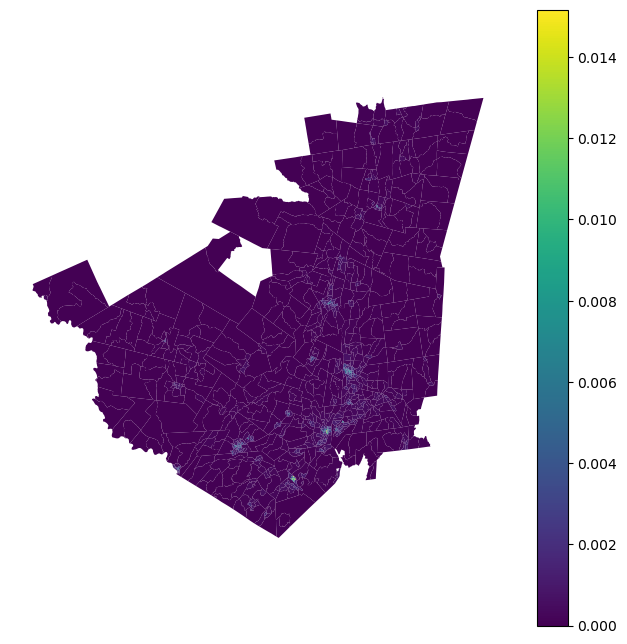

In [109]:
gdf_bgs_core_2022.assign(pop_area = lambda df: df.B01003_001E/df.ALAND).plot(column="pop_area", legend=True, figsize=(8,8), missing_kwds={'hatch': '///', 'edgecolor': "black"}).set_axis_off()

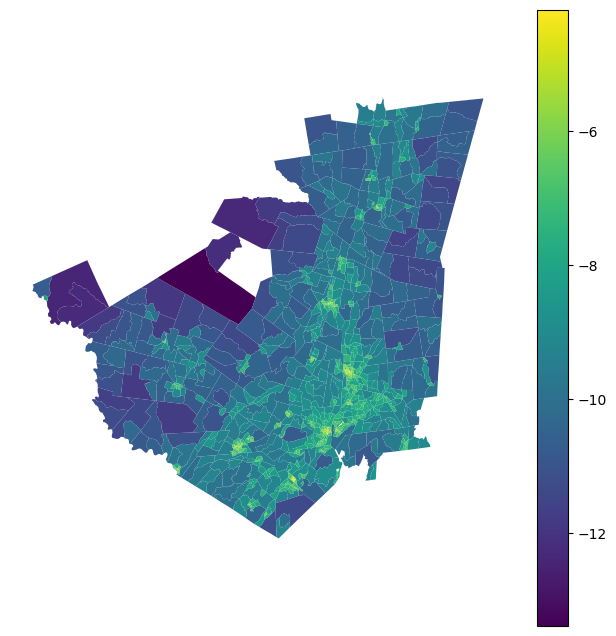

In [110]:
gdf_bgs_core_2022.assign(pop_area = lambda df: df.B01003_001E/df.ALAND).query('B01003_001E > 0').assign(pop_area = lambda df: df.pop_area.apply(math.log)).plot(column="pop_area", legend=True, figsize=(8,8), missing_kwds={'hatch': '///', 'edgecolor': "black"}).set_axis_off()

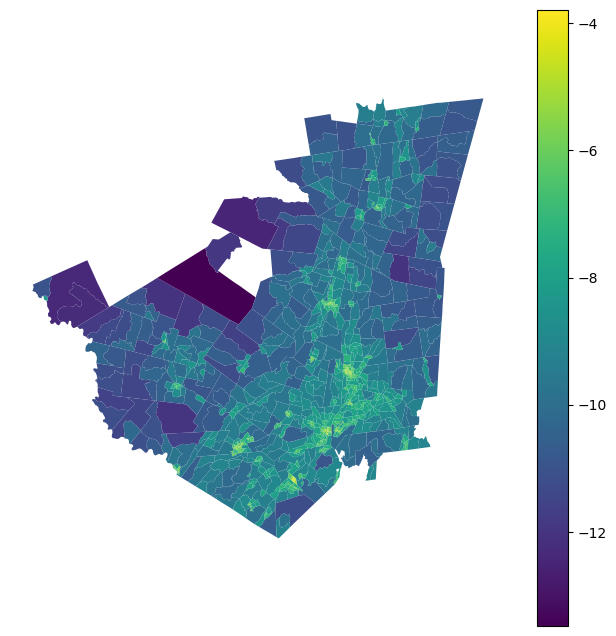

In [111]:
gdf_bgs_2022.merge(acs_bg_data_core[1].assign(GEOIDbg = lambda df: df.STATE + df.COUNTY + df.TRACT + df.BLOCK_GROUP), how="right", left_on="GEOID", right_on="GEOIDbg").assign(pop_area = lambda df: df.B01003_001E/df.ALAND).query('B01003_001E > 0').assign(pop_area = lambda df: df.pop_area.apply(math.log)).plot(column="pop_area", legend=True, figsize=(8,8), missing_kwds={'hatch': '///', 'edgecolor': "black"}).set_axis_off()

# Get Agriculture Census data

In [112]:
gdf_zctas = gpd.read_file("data/large_files/tl_2022_us_zcta520.zip")

In [113]:
gdf_zctas.head(1)

ZCTA5CE20 GEOID20 CLASSFP20 MTFCC20 FUNCSTAT20  ALAND20  AWATER20  \
0     47236   47236        B5   G6350          S  1029063         0   

    INTPTLAT20    INTPTLON20  \
0  +39.1517426  -085.7252769   

                                            geometry  
0  POLYGON ((-85.7341 39.15597, -85.72794 39.1561...

In [114]:
zipcodes = list(gdf_zctas.to_crs(proj_hudson_ft).sjoin(gdf_tracts_core_2022.to_crs(proj_hudson_ft), how="inner", predicate="intersects").ZCTA5CE20.unique())

In [115]:
gdf_zctas.query("ZCTA5CE20 in @zipcodes").to_crs(proj_hudson_ft).to_file("data/zctas_core.geojson")

In [ ]:
gpd.overlay(gdf_zctas.to_crs(proj_hudson_ft), gdf_tracts_core_2022.to_crs(proj_hudson_ft), how="intersection").plot()

<Axes: >

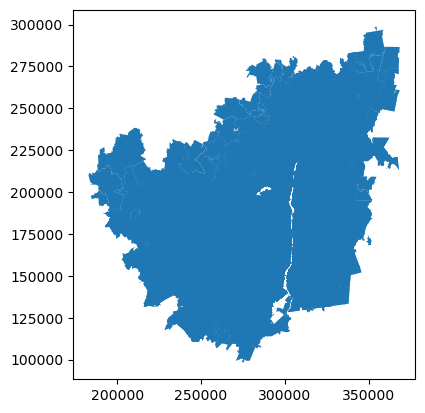

In [ ]:
gdf_zctas.to_crs(proj_hudson_ft).sjoin(gdf_tracts_core_2022.to_crs(proj_hudson_ft), how="inner", predicate="intersects").plot()

In [ ]:
gdf_zctas.to_crs(proj_hudson_ft).sjoin(gdf_tracts_core_2022.to_crs(proj_hudson_ft), how="inner", predicate="intersects").head()

ZCTA5CE20 GEOID20 CLASSFP20 MTFCC20 FUNCSTAT20   ALAND20  AWATER20  \
8962     12577   12577        B5   G6350          S  19999901    169531   
8962     12577   12577        B5   G6350          S  19999901    169531   
8962     12577   12577        B5   G6350          S  19999901    169531   
8962     12577   12577        B5   G6350          S  19999901    169531   
8962     12577   12577        B5   G6350          S  19999901    169531   

       INTPTLAT20    INTPTLON20  \
8962  +41.4214832  -074.1168149   
8962  +41.4214832  -074.1168149   
8962  +41.4214832  -074.1168149   
8962  +41.4214832  -074.1168149   
8962  +41.4214832  -074.1168149   

                                               geometry  ...        GEOID  \
8962  POLYGON ((288257.82 142661.193, 288349.37 1426...  ...  36071013500   
8962  POLYGON ((288257.82 142661.193, 288349.37 1426...  ...  36071013100   
8962  POLYGON ((288257.82 142661.193, 288349.37 1426...  ...  36071013201   
8962  POLYGON ((288257.82 142661.193, 288349.37 1426...  ...  36071013301   
8962  POLYGON ((288257.82 142661.193, 288349.37 1426...  ...  36071015201   

        NAME             NAMELSAD  MTFCC FUNCSTAT     ALAND   AWATER  \
8962     135     Census Tract 135  G5020        S  20865319   473491   
8962     131     Census Tract 131  G5020        S  67934560  3259792   
8962  132.01  Census Tract 132.01  G5020        S   7186929   276104   
8962  133.01  Census Tract 133.01  G5020        S  30658182   835555   
8962  152.01  Census Tract 152.01  G5020        S  23604202   420742   

         INTPTLAT      INTPTLON  COUNTYFIPS  
8962  +41.3662271  -074.1212864       36071  
8962  +41.4161572  -074.0430642       36071  
8962  +41.4331148  -074.1342857       36071  
8962  +41.4029234  -074.1670509       36071  
8962  +41.4572048  -074.1473672       36071  

[5 rows x 24 columns]

In [ ]:
county_codes = [code[2:] for code in gdf_counties_core.FIPS_CODE]
county_codes

['001', '021', '025', '027', '039', '071', '079', '083', '105', '111']

In [ ]:
url_get = f"https://quickstats.nass.usda.gov/api/api_GET/?key={api_key_nass}"
url_getcounts = f"https://quickstats.nass.usda.gov/api/get_counts/?key={api_key_nass}"

ag_params = {
    "source_desc": "CENSUS",
    "sector_desc": "DEMOGRAPHICS,ECONOMICS", # Crops, Animals & Products, Economics, Demographics, and Environmental
    "group_desc": ",".join(['EXPENSES','FARMS & LAND & ASSETS','INCOME','PRODUCERS']), 
    "commodity_desc": "",
    "agg_level_desc": "Zip Code",
    "state_fips_code": "36",
    "county_code": ",".join(county_codes),
    "year": "2017,2022",
    "format": "json"
}

In [ ]:
nass_param_vals = []
for param in ["sector_desc","group_desc","commodity_desc","class_desc","statisticcat_desc","unit_desc","short_desc","domain_desc"]:
    r = requests.get(f"https://quickstats.nass.usda.gov/api/get_param_values/?key={api_key_nass}&param={param}").json()
    nass_param_vals.append(r)

In [ ]:
requests.get(f"https://quickstats.nass.usda.gov/api/get_param_values/?key={api_key_nass}", params={"param": "sector_desc"}).json()

{'sector_desc': ['ANIMALS & PRODUCTS',
  'CROPS',
  'DEMOGRAPHICS',
  'ECONOMICS',
  'ENVIRONMENTAL']}

In [ ]:
nass_param_vals

[{'sector_desc': ['ANIMALS & PRODUCTS',
   'CROPS',
   'DEMOGRAPHICS',
   'ECONOMICS',
   'ENVIRONMENTAL']},
 {'group_desc': ['ANIMAL TOTALS',
   'AQUACULTURE',
   'COMMODITIES',
   'CROP TOTALS',
   'DAIRY',
   'ENERGY',
   'EXPENSES',
   'FARMS & LAND & ASSETS',
   'FIELD CROPS',
   'FRUIT & TREE NUTS',
   'HORTICULTURE',
   'INCOME',
   'IRRIGATION',
   'LIVESTOCK',
   'OPERATORS',
   'POULTRY',
   'PRICES PAID',
   'PRODUCERS',
   'SPECIALTY',
   'VEGETABLES']},
 {'commodity_desc': ['AG LAND',
   'AG SERVICES',
   'AG SERVICES & RENT',
   'ALCOHOL COPRODUCTS',
   'ALMONDS',
   'ALPACAS',
   'AMARANTH',
   'ANIMAL PRODUCTS, OTHER',
   'ANIMAL SECTOR',
   'ANIMAL TOTALS',
   'ANIMALS, OTHER',
   'ANNUAL PPI',
   'APPLES',
   'APRICOTS',
   'AQUACULTURE TOTALS',
   'AQUACULTURE, OTHER',
   'AQUATIC PLANTS',
   'ARONIA BERRIES',
   'ARTICHOKES',
   'ASPARAGUS',
   'ASSETS',
   'AUTOMOBILES',
   'AUTOS',
   'AVOCADOS',
   'BAITFISH',
   'BANANAS',
   'BAREROOT HERBACEOUS PERENNIALS',
  

In [ ]:
for val in nass_param_vals[-1]['domain_desc']:
    if 'tenure' in val.lower():
        print(val)

AREA OPERATED AND TENURE
CHEMICAL & FERTILIZER AND TENURE
CHEMICAL, FUNGICIDE AND TENURE
CHEMICAL, HERBICIDE AND TENURE
CHEMICAL, INSECTICIDE AND TENURE
ECONOMIC CLASS AND TENURE
FAMILIES SHARING NET INCOME AND TENURE
FARM SALES AND TENURE
FERTILIZER AND TENURE
HOUSEHOLD SIZE AND TENURE
IRRIGATION METHOD AND TENURE
NAICS CLASSIFICATION AND TENURE
OPERATORS AND TENURE
OPERATORS, AGE AND TENURE
OPERATORS, PRINCIPAL AND TENURE
OPERATORS, PRINCIPAL, HOUSEHOLD INCOME AND TENURE
OPERATORS, PRINCIPAL, ON PRESENT OPERATION AND TENURE
ORGANIZATION AND TENURE
PRODUCERS AND TENURE
PRODUCERS, AGE AND TENURE
TENURE
TENURE AND AREA BEARING & NON-BEARING
TENURE AND AREA HARVESTED
TENURE AND AREA HARVESTED, FRESH MARKET & PROCESSING
TENURE AND AREA IN PRODUCTION
TENURE AND AREA OPERATED
TENURE AND CHEMICAL, FUNGICIDE
TENURE AND CHEMICAL, HERBICIDE
TENURE AND CHEMICAL, INSECTICIDE
TENURE AND CHEMICAL, OTHER
TENURE AND ECONOMIC CLASS
TENURE AND EXPENSE
TENURE AND FARM OPERATIONS
TENURE AND FERTILIZER
TE

In [ ]:
nass_param_vals[-2]['short_desc']

['AG LAND - ACRES',
 'AG LAND - NUMBER OF OPERATIONS',
 'AG LAND - OPERATIONS WITH TREATED',
 'AG LAND - TREATED, MEASURED IN ACRES',
 'AG LAND - TREATED, MEASURED IN CUERDAS',
 'AG LAND, (EXCL CROPLAND & PASTURELAND & WOODLAND) - ACRES',
 'AG LAND, (EXCL CROPLAND & PASTURELAND & WOODLAND) - AREA, MEASURED IN PCT OF AG LAND',
 'AG LAND, (EXCL CROPLAND & PASTURELAND & WOODLAND) - AREA, MEASURED IN PCT OF FARM OPERATIONS',
 'AG LAND, (EXCL CROPLAND & PASTURELAND & WOODLAND) - CUERDAS',
 'AG LAND, (EXCL CROPLAND & PASTURELAND & WOODLAND) - NUMBER OF OPERATIONS',
 'AG LAND, (EXCL CROPLAND & PASTURELAND) - ACRES',
 'AG LAND, (EXCL CROPLAND & PASTURELAND) - NUMBER OF OPERATIONS',
 'AG LAND, (EXCL CROPLAND & PASTURELAND), OWNED, RENTED TO OTHERS - ACRES',
 'AG LAND, (EXCL CROPLAND & PASTURELAND), OWNED, RENTED TO OTHERS - AREA, MEASURED IN COUNT',
 'AG LAND, (EXCL HARVESTED CROPLAND), IRRIGATED - ACRES',
 'AG LAND, (EXCL HARVESTED CROPLAND), IRRIGATED - NUMBER OF OPERATIONS',
 'AG LAND, AGRIC

In [ ]:
for val in nass_param_vals[-2]['short_desc']:
    if 'asset value' in val.lower():
        print(val)

AG LAND, CROPLAND - ASSET VALUE, MEASURED IN $ / ACRE
AG LAND, CROPLAND, IRRIGATED - ASSET VALUE, MEASURED IN $ / ACRE
AG LAND, CROPLAND, NON-IRRIGATED - ASSET VALUE, MEASURED IN $ / ACRE
AG LAND, INCL BUILDINGS - ASSET VALUE, MEASURED IN $
AG LAND, INCL BUILDINGS - ASSET VALUE, MEASURED IN $ / ACRE
AG LAND, INCL BUILDINGS - ASSET VALUE, MEASURED IN $ / OPERATION
AG LAND, INCL BUILDINGS - OPERATIONS WITH ASSET VALUE
AG LAND, INCL BUILDINGS, (FOR HORTICULTURE) - ASSET VALUE, MEASURED IN $
AG LAND, INCL BUILDINGS, (FOR HORTICULTURE) - OPERATIONS WITH ASSET VALUE
AG LAND, INCL BUILDINGS, RENTED TO OTHERS - ASSET VALUE, MEASURED IN $
AG LAND, INCL BUILDINGS, RENTED TO OTHERS - ASSET VALUE, MEASURED IN COUNT
AG LAND, PASTURELAND - ASSET VALUE, MEASURED IN $ / ACRE
ASSETS, (EXCL LAND & BUILDINGS), ASSOCIATED WITH AG LAND, OWNED, RENTED TO OTHERS - ASSET VALUE, MEASURED IN $
ASSETS, (EXCL LAND & BUILDINGS), ASSOCIATED WITH AG LAND, OWNED, RENTED TO OTHERS - ASSET VALUE, MEASURED IN COUNT
ASSE

In [ ]:
for val in nass_param_vals[-2]['short_desc']:
    if 'tenure' in val.lower():
        print(val)

In [ ]:
requests.get(f"https://quickstats.nass.usda.gov/api/get_param_values/?key={api_key_nass}", params={"param": "commodity_desc", "sector_desc": "DEMOGRAPHICS", "year": "2017", "state_fips_code": "36"}).json()

{'commodity_desc': ['AG LAND',
  'AG SERVICES',
  'ANIMAL TOTALS',
  'APPLES',
  'AQUACULTURE TOTALS',
  'BARLEY',
  'BEANS',
  'BERRY TOTALS',
  'CABBAGE',
  'CATTLE',
  'CCC LOANS',
  'CHEMICAL TOTALS',
  'CHICKENS',
  'CITRUS TOTALS',
  'COMMODITY TOTALS',
  'CORN',
  'CROP TOTALS',
  'CUT CHRISTMAS TREES',
  'CUT CHRISTMAS TREES & SHORT TERM WOODY TREES',
  'DEPRECIATION',
  'ENERGY',
  'EQUINE',
  'EXPENSE TOTALS',
  'FARM OPERATIONS',
  'FEED',
  'FERTILIZER',
  'FERTILIZER TOTALS',
  'FIELD CROPS, OTHER',
  'FRUIT & TREE NUT TOTALS',
  'FUELS',
  'GOATS',
  'GOVT PROGRAMS',
  'GRAIN',
  'GRAPES',
  'GRASSES & LEGUMES TOTALS',
  'HAY',
  'HAY & HAYLAGE',
  'HOGS',
  'HORTICULTURE TOTALS',
  'INCOME, FARM-RELATED',
  'INCOME, NET CASH FARM',
  'INTEREST',
  'INTERNET',
  'LABOR',
  'MACHINERY TOTALS',
  'MACHINERY, OTHER',
  'MAPLE SYRUP',
  'MILK',
  'NURSERY TOTALS',
  'OATS',
  'ORCHARDS',
  'PEACHES',
  'PEAS',
  'PECANS',
  'POTATOES',
  'POULTRY TOTALS',
  'PRACTICES',
  'PR

In [ ]:
county_fips

['105', '001', '111', '027', '071', '039', '079', '021', '083', '025']

In [ ]:
requests.get(url=f'https://quickstats.nass.usda.gov/api/get_counts/?key={api_key_nass}', params={"sector_desc": "DEMOGRAPHICS", "year": "2017", "state_fips_code": "36", "agg_level_desc": "ZIP CODE"}).json()

{'count': 19578}

In [ ]:
r = requests.get(url=url_get, params={"sector_desc": "DEMOGRAPHICS", "year": "2017", "state_fips_code": "36", "agg_level_desc": "ZIP CODE"}).json()

In [ ]:
ny_demographics_df = pd.DataFrame.from_dict(r['data'])

In [ ]:
ny_demographics_df.head()

watershed_desc begin_code                load_time watershed_code end_code  \
0                        00  2018-02-01 12:00:00.000       00000000       00   
1                        00  2018-02-01 12:00:00.000       00000000       00   
2                        00  2018-02-01 12:00:00.000       00000000       00   
3                        00  2018-02-01 12:00:00.000       00000000       00   
4                        00  2018-02-01 12:00:00.000       00000000       00   

         domaincat_desc freq_desc   commodity_desc asd_code state_fips_code  \
0  TENURE: (FULL OWNER)    ANNUAL  FARM OPERATIONS                       36   
1  TENURE: (FULL OWNER)    ANNUAL  FARM OPERATIONS                       36   
2  TENURE: (FULL OWNER)    ANNUAL  FARM OPERATIONS                       36   
3  TENURE: (FULL OWNER)    ANNUAL  FARM OPERATIONS                       36   
4  TENURE: (FULL OWNER)    ANNUAL  FARM OPERATIONS                       36   

   ... county_code  zip_5 state_ansi state_alpha state_name  year  \
0  ...              10001         36          NY   NEW YORK  2017   
1  ...              10003         36          NY   NEW YORK  2017   
2  ...              10010         36          NY   NEW YORK  2017   
3  ...              10012         36          NY   NEW YORK  2017   
4  ...              10016         36          NY   NEW YORK  2017   

          util_practice_desc county_name location_desc asd_desc  
0  ALL UTILIZATION PRACTICES                     10001           
1  ALL UTILIZATION PRACTICES                     10003           
2  ALL UTILIZATION PRACTICES                     10010           
3  ALL UTILIZATION PRACTICES                     10012           
4  ALL UTILIZATION PRACTICES                     10016           

[5 rows x 39 columns]

In [ ]:
ny_demographics_df.columns

Index(['watershed_desc', 'begin_code', 'load_time', 'watershed_code',
       'end_code', 'domaincat_desc', 'freq_desc', 'commodity_desc', 'asd_code',
       'state_fips_code', 'prodn_practice_desc', 'country_name', 'sector_desc',
       'week_ending', 'unit_desc', 'group_desc', 'region_desc', 'short_desc',
       'reference_period_desc', 'Value', 'county_ansi', 'agg_level_desc',
       'congr_district_code', 'statisticcat_desc', 'domain_desc',
       'source_desc', 'country_code', 'CV (%)', 'class_desc', 'county_code',
       'zip_5', 'state_ansi', 'state_alpha', 'state_name', 'year',
       'util_practice_desc', 'county_name', 'location_desc', 'asd_desc'],
      dtype='object')

In [ ]:
demographics_cols = []
for col in ny_demographics_df.columns:
    nunique = ny_demographics_df[col].nunique()
    if nunique > 1:
        print(col, nunique)
        demographics_cols.append(col)

domaincat_desc 9
commodity_desc 3
prodn_practice_desc 13
unit_desc 2
group_desc 2
short_desc 17
Value 231
statisticcat_desc 2
domain_desc 3
class_desc 4
zip_5 1337
location_desc 1337


In [ ]:
ny_demographics_df[demographics_cols].head()

domaincat_desc   commodity_desc       prodn_practice_desc  \
0  TENURE: (FULL OWNER)  FARM OPERATIONS  ALL PRODUCTION PRACTICES   
1  TENURE: (FULL OWNER)  FARM OPERATIONS  ALL PRODUCTION PRACTICES   
2  TENURE: (FULL OWNER)  FARM OPERATIONS  ALL PRODUCTION PRACTICES   
3  TENURE: (FULL OWNER)  FARM OPERATIONS  ALL PRODUCTION PRACTICES   
4  TENURE: (FULL OWNER)  FARM OPERATIONS  ALL PRODUCTION PRACTICES   

    unit_desc             group_desc                              short_desc  \
0  OPERATIONS  FARMS & LAND & ASSETS  FARM OPERATIONS - NUMBER OF OPERATIONS   
1  OPERATIONS  FARMS & LAND & ASSETS  FARM OPERATIONS - NUMBER OF OPERATIONS   
2  OPERATIONS  FARMS & LAND & ASSETS  FARM OPERATIONS - NUMBER OF OPERATIONS   
3  OPERATIONS  FARMS & LAND & ASSETS  FARM OPERATIONS - NUMBER OF OPERATIONS   
4  OPERATIONS  FARMS & LAND & ASSETS  FARM OPERATIONS - NUMBER OF OPERATIONS   

  Value statisticcat_desc domain_desc   class_desc  zip_5 location_desc  
0     4        OPERATIONS      TENURE  ALL CLASSES  10001         10001  
1     1        OPERATIONS      TENURE  ALL CLASSES  10003         10003  
2     2        OPERATIONS      TENURE  ALL CLASSES  10010         10010  
3     2        OPERATIONS      TENURE  ALL CLASSES  10012         10012  
4     2        OPERATIONS      TENURE  ALL CLASSES  10016         10016

In [ ]:
demographics = {}
for col in demographics_cols:
    demographics[col] = list(ny_demographics_df[col].unique())

In [ ]:
demographics['commodity_desc']

['FARM OPERATIONS', 'INTERNET', 'PRODUCERS']

In [ ]:
ny_demographics_df[demographics_cols].query('domain_desc == "TENURE"').domaincat_desc.unique()

array(['TENURE: (FULL OWNER)', 'TENURE: (PART OWNER)', 'TENURE: (TENANT)'],
      dtype=object)

In [ ]:
ny_demographics_df[demographics_cols].domaincat_desc.unique()

array(['TENURE: (FULL OWNER)', 'TENURE: (PART OWNER)', 'TENURE: (TENANT)',
       'NOT SPECIFIED', 'PRODUCERS: (1 PRODUCERS)',
       'PRODUCERS: (2 PRODUCERS)', 'PRODUCERS: (3 PRODUCERS)',
       'PRODUCERS: (4 PRODUCERS)', 'PRODUCERS: (5 OR MORE PRODUCERS)'],
      dtype=object)

In [ ]:
for key in demographics.keys():
    print(key)
    print(demographics[key])

domaincat_desc
['TENURE: (FULL OWNER)', 'TENURE: (PART OWNER)', 'TENURE: (TENANT)', 'NOT SPECIFIED', 'PRODUCERS: (1 PRODUCERS)', 'PRODUCERS: (2 PRODUCERS)', 'PRODUCERS: (3 PRODUCERS)', 'PRODUCERS: (4 PRODUCERS)', 'PRODUCERS: (5 OR MORE PRODUCERS)']
commodity_desc
['FARM OPERATIONS', 'INTERNET', 'PRODUCERS']
prodn_practice_desc
['ALL PRODUCTION PRACTICES', 'ACCESS', 'ACCESS, VIA CABLE', 'ACCESS, VIA DIALUP', 'ACCESS, VIA DSL', 'ACCESS, VIA FIBER OPTIC', 'ACCESS, VIA MOBILE', 'ACCESS, VIA OTHER', 'ACCESS, VIA SATELLITE', 'ACCESS, VIA UNKNOWN METHOD', 'DAYS WORKED OFF OPERATION, GE 200 DAYS', 'PRIMARY OCCUPATION, FARMING', 'RESIDENCE, ON OPERATION']
unit_desc
['OPERATIONS', 'PRODUCERS']
group_desc
['FARMS & LAND & ASSETS', 'PRODUCERS']
short_desc
['FARM OPERATIONS - NUMBER OF OPERATIONS', 'INTERNET, ACCESS - NUMBER OF OPERATIONS', 'INTERNET, ACCESS, VIA CABLE - NUMBER OF OPERATIONS', 'INTERNET, ACCESS, VIA DIALUP - NUMBER OF OPERATIONS', 'INTERNET, ACCESS, VIA DSL - NUMBER OF OPERATIONS',

In [ ]:
demographics['group_desc']

['FARMS & LAND & ASSETS', 'PRODUCERS']

In [ ]:
short_desc_cols = ["commodity_desc", "class_desc", "prodn_practice_desc", "util_practice_desc", "statisticcat_desc", "unit_desc"]

In [ ]:
ny_demographics_df[demographics_cols].groupby(["group_desc","commodity_desc", "class_desc", "prodn_practice_desc", "statisticcat_desc", "unit_desc","domain_desc","domaincat_desc"]).size()

group_desc             commodity_desc   class_desc   prodn_practice_desc                     statisticcat_desc  unit_desc   domain_desc  domaincat_desc                  
FARMS & LAND & ASSETS  FARM OPERATIONS  ALL CLASSES  ALL PRODUCTION PRACTICES                OPERATIONS         OPERATIONS  TENURE       TENURE: (FULL OWNER)                1237
                                                                                                                                         TENURE: (PART OWNER)                 954
                                                                                                                                         TENURE: (TENANT)                     455
                       INTERNET         ALL CLASSES  ACCESS                                  OPERATIONS         OPERATIONS  TOTAL        NOT SPECIFIED                       1274
                                                     ACCESS, VIA CABLE                       OPERATIONS         OPERAT

In [ ]:
ny_demographics_df[demographics_cols].groupby(["group_desc","commodity_desc", "class_desc", "prodn_practice_desc", "statisticcat_desc", "unit_desc","domain_desc","domaincat_desc"]).size().reset_index().drop(0,axis=1)

group_desc   commodity_desc   class_desc  \
0   FARMS & LAND & ASSETS  FARM OPERATIONS  ALL CLASSES   
1   FARMS & LAND & ASSETS  FARM OPERATIONS  ALL CLASSES   
2   FARMS & LAND & ASSETS  FARM OPERATIONS  ALL CLASSES   
3   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
4   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
5   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
6   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
7   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
8   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
9   FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
10  FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
11  FARMS & LAND & ASSETS         INTERNET  ALL CLASSES   
12              PRODUCERS        PRODUCERS        (ALL)   
13              PRODUCERS        PRODUCERS  ALL CLASSES   
14              PRODUCERS        PRODUCERS  ALL CLASSES   
15              PRODUCERS        PRODUCERS  ALL CLASSES   
16              PRODUCERS        PRODUCERS  ALL CLASSES   
17              PRODUCERS        PRODUCERS  ALL CLASSES   
18              PRODUCERS        PRODUCERS  ALL CLASSES   
19              PRODUCERS        PRODUCERS  ALL CLASSES   
20              PRODUCERS        PRODUCERS  ALL CLASSES   
21              PRODUCERS        PRODUCERS       FEMALE   
22              PRODUCERS        PRODUCERS         MALE   

                       prodn_practice_desc statisticcat_desc   unit_desc  \
0                 ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
1                 ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
2                 ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
3                                   ACCESS        OPERATIONS  OPERATIONS   
4                        ACCESS, VIA CABLE        OPERATIONS  OPERATIONS   
5                       ACCESS, VIA DIALUP        OPERATIONS  OPERATIONS   
6                          ACCESS, VIA DSL        OPERATIONS  OPERATIONS   
7                  ACCESS, VIA FIBER OPTIC        OPERATIONS  OPERATIONS   
8                       ACCESS, VIA MOBILE        OPERATIONS  OPERATIONS   
9                        ACCESS, VIA OTHER        OPERATIONS  OPERATIONS   
10                   ACCESS, VIA SATELLITE        OPERATIONS  OPERATIONS   
11              ACCESS, VIA UNKNOWN METHOD        OPERATIONS  OPERATIONS   
12                ALL PRODUCTION PRACTICES         PRODUCERS   PRODUCERS   
13                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
14                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
15                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
16                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
17                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
18  DAYS WORKED OFF OPERATION, GE 200 DAYS         PRODUCERS   PRODUCERS   
19             PRIMARY OCCUPATION, FARMING         PRODUCERS   PRODUCERS   
20                 RESIDENCE, ON OPERATION         PRODUCERS   PRODUCERS   
21                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   
22                ALL PRODUCTION PRACTICES        OPERATIONS  OPERATIONS   

   domain_desc                    domaincat_desc  
0       TENURE              TENURE: (FULL OWNER)  
1       TENURE              TENURE: (PART OWNER)  
2       TENURE                  TENURE: (TENANT)  
3        TOTAL                     NOT SPECIFIED  
4        TOTAL                     NOT SPECIFIED  
5        TOTAL                     NOT SPECIFIED  
6        TOTAL                     NOT SPECIFIED  
7        TOTAL                     NOT SPECIFIED  
8        TOTAL                     NOT SPECIFIED  
9        TOTAL                     NOT SPECIFIED  
10       TOTAL                     NOT SPECIFIED  
11       TOTAL                     NOT SPECIFIED  
12       TOTAL                     NOT SPECIFIED  
13   PRODUCERS          PRODUCERS: (1 PRODUCERS)  
14   PRO

In [ ]:
[col for col in demographics_cols if col not in short_desc_cols]

['domaincat_desc',
 'group_desc',
 'short_desc',
 'Value',
 'domain_desc',
 'zip_5',
 'location_desc']